## Setup

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

In [ ]:
%matplotlib inline

In [ ]:
%pip install transformers
%pip install keras_tuner

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, LSTM, Bidirectional as Bi, Embedding
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib import pyplot as plt

2023-02-07 20:22:45.962239: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-07 20:22:46.298761: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
import torch
from transformers import AutoModelForSequenceClassification, AdamW, AutoTokenizer, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
df = pd.read_csv('./cs01_dataset.csv')

In [ ]:
answers = dict()
answers['Irrelevant'] = [
    "I'm sorry, I can't help you with that.",
    "I'm sorry, my responses are limited. You'll have to ask the right question.",
    "I don't know how to respond to that, I'm afraid."]
answers['Applications'] = [
    "You can find out more about the applications in the applications page: <br><a href=https://aidl.uniwa.gr/applications/>Applications</a>",
    "If you are interested in applying you can start here: <br><a href=https://aidl.uniwa.gr/applications/>Applications</a>",
    "For more info about the application process you can visit this link: <br><a href=https://aidl.uniwa.gr/applications/>Applications</a>"
]
answers['Contact'] = [
    "If you would like to contact us, you can check out this link: <br><a href=https://aidl.uniwa.gr/contact/>Contact</a>",
    "To get in contact with the MSc. Administration you can visit this link: <br><a href=https://aidl.uniwa.gr/contact/>Contact</a>",
    "Please feel free to reach out to us here: <br><a href=https://aidl.uniwa.gr/contact/>Contact</a>"
]
answers['Curriculum'] = [
    "Here you can find more info about the course curriculum: <br><a href=https://aidl.uniwa.gr/all-courses/>Course Curriculum</a>",
    "For a list of the courses and details about them have a look here: <br><a href=https://aidl.uniwa.gr/all-courses/>Course Curriculum</a>",
    "I think you'll be able to answer your question here: <br><a href=https://aidl.uniwa.gr/all-courses/>Course Curriculum</a>"
]
answers['Schedule'] = [
    "<br>Here is more information about the course schedule: <a href=https://aidl.uniwa.gr/course-schedule/>Course Schedule</a>",
    "<br>You can find more info about the schedule here: <a href=https://aidl.uniwa.gr/course-schedule/>Course Schedule</a>",
    "<br>The details of where and when the courses take place are in this page: <a href=https://aidl.uniwa.gr/course-schedule/>Course Schedule</a>"
]
answers['Documents'] = [
    "<br>You can find helpful documents on this page: <a href=https://aidl.uniwa.gr/mscdocuments/>Documents</a>",
    "<br>It sounds like you're looking for a document or template. This might help: <a href=https://aidl.uniwa.gr/mscdocuments/>Documents</a>",
    "<br>Feel free to download and use one of these templates: <a href=https://aidl.uniwa.gr/mscdocuments/>Documents</a>"
]
answers['Fees'] = [
    "<br>For more information about the cost of tuition you can visit this page: <a href=https://aidl.uniwa.gr/tuition-fees/>Fees</a>",
    "<br>I'm glad you're interested in applying, check out this info on the financials: <a href=https://aidl.uniwa.gr/tuition-fees/>Fees</a>",
    "<br>This page has the details on the program's costs: <a href=https://aidl.uniwa.gr/tuition-fees/>Fees</a>"
]
answers['Instructors'] = [
    "<br>For more info on the instructors look here: <a href=https://aidl.uniwa.gr/instructors/>Instructors</a>",
    "<br>This is a list of the instructors of the program: <a href=https://aidl.uniwa.gr/instructors/>Instructors</a>",
    "<br>Here is a useful link to find out more about the faculty: <a href=https://aidl.uniwa.gr/instructors/>Instructors</a>"
]
answers['Invited'] = [
    "<br>It sounds like you might have a question about an invited lecturer. More info here: <a href=https://aidl.uniwa.gr/invited-lecturers-2/>Invited Lecturers</a>",
    "<br>Are you interested in seeing a list of the invited lecturers? <a href=https://aidl.uniwa.gr/invited-lecturers-2/>Invited Lecturers</a>",
    "<br>For more details on the lecturers who are not members of faculty you can visit this page: <a href=https://aidl.uniwa.gr/invited-lecturers-2/>Invited Lecturers</a>"
]
answers['Registry'] = [
    "<br>You can find a lot of useful info and tools on the student registry page: <a href=https://aidl.uniwa.gr/student-registry/>Student Registry</a>",
    "<br>Perhaps the student registry can help you achieve what you're looking for: <a href=https://aidl.uniwa.gr/student-registry/>Student Registry</a>",
    "<br>This page can lead you to a tool that helps with various bureaucratic procedures: <a href=https://aidl.uniwa.gr/student-registry/>Student Registry</a>"
]

## Data exploration

Let's take a look at the data we're dealing with:

In [ ]:
df.head()

,ID,Question,Intent
0,000_0018,Is there a parking lot?,Irrelevant
1,001_0018,Is this program easy?,Irrelevant
2,002_0018,Do most students pass the exams?,Irrelevant
3,003_0018,How many students are currently enrolled?,Irrelevant
4,004_0018,Are there any buses from university to Piraeus?,Irrelevant


In [ ]:
df['Intent'].value_counts()

Instructors     576
Curriculum      535
Irrelevant      452
Applications    450
Schedule        446
Documents       437
Contact         436
Fees            406
Invited         374
Registry        370
Name: Intent, dtype: int64

We can see that the dataset is relatively balanced, with the largest class only being about x1.5 the size of the smallest.

In [ ]:
labels = list(df['Intent'].drop_duplicates())
num_labels = len(labels)
print(labels, num_labels)

['Irrelevant', 'Applications', 'Contact', 'Curriculum', 'Schedule', 'Documents', 'Fees', 'Instructors', 'Invited', 'Registry'] 10


Now let's take a look at the distribution of the questions' length in words:

In [ ]:
df['Question'].apply(lambda x: len(x.split())).describe()

count    4482.000000
mean        7.825971
std         2.803394
min         1.000000
25%         6.000000
50%         7.000000
75%         9.000000
max        28.000000
Name: Question, dtype: float64

In [ ]:
sorted([len(i.split()) for i in df['Question']])[int(len(df)*0.99)]

16

As we can see, 99% of questions are at or under 16 words. This is a nice, round number, so we will use it as the maximum length going forward.

In [ ]:
max_sequence_length = 16

## Data preparation

In [ ]:
X = df['Question'].to_numpy()
y = np.array([labels.index(label) for label in df['Intent']])

In [ ]:
X_train_val, X_test, y_train_val, y_test_int = train_test_split(X, y, test_size=0.2, random_state=21010034, stratify=y)
X_train, X_val, y_train_int, y_val_int = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=21010034, stratify=y_train_val)

## LSTM

We will start by manually creating a reference model, which we will tune later.

In [ ]:
vocabulary_size = None
normalization = 'lower_and_strip_punctuation'
max_sequence_length = 16
embedding_size = 100
learning_rate = 0.001
batch_size = 128
epochs = 100
early_stopping_patience = 10

The LSTM models need the output labels to be 1-hot encoded, so we will convert them here:

In [ ]:
def one_hot(label):
    return [int(i == label) for i in range(num_labels)]

In [ ]:
X_train = tf.convert_to_tensor(X_train)
X_test = tf.convert_to_tensor(X_test)
X_val = tf.convert_to_tensor(X_val)

y_train = tf.convert_to_tensor(np.array([one_hot(label) for label in y_train_int]))
y_test = tf.convert_to_tensor(np.array([one_hot(label) for label in y_test_int]))
y_val = tf.convert_to_tensor(np.array([one_hot(label) for label in y_val_int]))

2023-02-06 22:27:29.255255: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-06 22:27:29.395622: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-06 22:27:29.395911: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-06 22:27:29.399020: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

### Vectorizer

We'll use tf's TextVectorization layer, which takes care of fitting the vocabulary, tokenization, vectorization, padding and truncation.

In [ ]:
vectorizer = TextVectorization(output_sequence_length=max_sequence_length, max_tokens=vocabulary_size)
vectorizer.adapt(X_train)
vocabulary = vectorizer.get_vocabulary()
vocabulary_size = len(vocabulary)
word_index = dict(zip(vocabulary, range(vocabulary_size)))

We'll make a note of the total number of words in the vocabulary:

In [ ]:
total_vocabulary_size = vocabulary_size
print(total_vocabulary_size)

1707


### Embeddings

We will first try to use an unitialized embedding layer that will be trained as part of the network:

In [ ]:
embedding_layer = Embedding(
            vocabulary_size+2,
            embedding_size,
            trainable=True,
            input_length=max_sequence_length
        )

### Glove embeddings

This is code to create an embedding layer using glove embeddings. It will not be used for the reference model, but it was used for manual testing and it is integrated within the Bayesian tuning later on.

In [ ]:
embeddings_index = {}
with open(f'./glove.6B.{embedding_size}d.txt') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

In [ ]:
embedding_matrix = np.zeros((vocabulary_size+2, embedding_size))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:

glove_embedding_layer = Embedding(
    vocabulary_size+2,
    embedding_size,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False,
    input_length=max_sequence_length
)

### Reference model

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,), dtype=tf.string),
    vectorizer,
    embedding_layer,
    Bi(LSTM(128, return_sequences=True)),
    tf.keras.layers.Dropout(0.5),
    Bi(LSTM(64)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_labels, activation='softmax')
])

In [ ]:
model.compile(tf.keras.optimizers.Adam(learning_rate=learning_rate),loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy', tf.keras.metrics.Precision()])

In [ ]:
early_stopping=tf.keras.callbacks.EarlyStopping(patience=early_stopping_patience, restore_best_weights=True, verbose=1)

In [ ]:
history=model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/100


2023-02-04 23:35:38.122405: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8700


21/21 [==============================] - 6s 64ms/step - loss: 2.2851 - accuracy: 0.1295 - precision: 0.0000e+00 - val_loss: 2.2564 - val_accuracy: 0.1538 - val_precision: 0.0000e+00
Epoch 2/100
21/21 [==============================] - 0s 12ms/step - loss: 2.1225 - accuracy: 0.2098 - precision: 0.6383 - val_loss: 1.9482 - val_accuracy: 0.3445 - val_precision: 0.9167
Epoch 3/100
21/21 [==============================] - 0s 11ms/step - loss: 1.5537 - accuracy: 0.4617 - precision: 0.7703 - val_loss: 1.3323 - val_accuracy: 0.5485 - val_precision: 0.8265
Epoch 4/100
21/21 [==============================] - 0s 11ms/step - loss: 0.9557 - accuracy: 0.6749 - precision: 0.8400 - val_loss: 0.9618 - val_accuracy: 0.6890 - val_precision: 0.8072
Epoch 5/100
21/21 [==============================] - 0s 11ms/step - loss: 0.5723 - accuracy: 0.8218 - precision: 0.8764 - val_loss: 0.8659 - val_accuracy: 0.7391 - val_precision: 0.7878
Epoch 6/100
21/21 [==============================] - 0s 11ms/step - loss: 

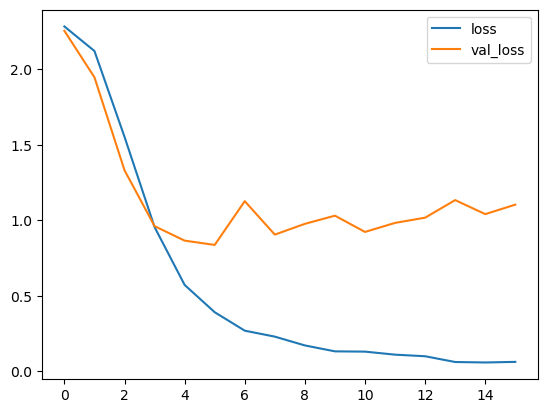

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])

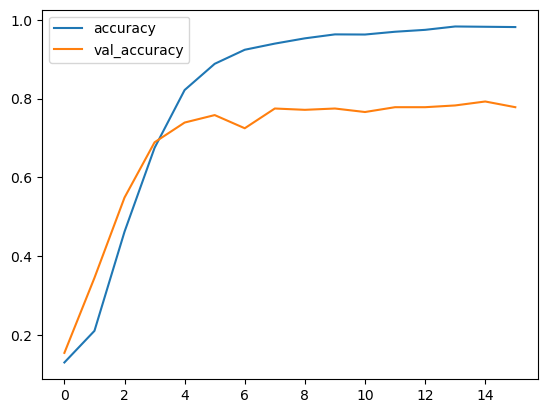

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])

As can be seen, the model reaches a minimum loss at epoch 5, with an accuracy of 74%, after which it slowly starts to overfit until it triggers the early stopping at epoch 16.

### Bayesian tuning

Next up we'll perform a Bayesian search using keras tuner to find the best hyperparameters.

In [ ]:
import keras_tuner as kt

We'll preload all the Glove embeddings into memory and save them in an index:

In [ ]:
embeddings_index = dict()
for embedding_size in [50, 100, 200, 300]:
    embeddings_index[embedding_size] = {}
    with open(f'./glove.6B.{embedding_size}d.txt') as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_index[embedding_size][word] = coefs


In [ ]:
def create_model(hp):
    max_sequence_length = hp.Choice('max_sequence_length', [10, 16, 20])
    vocabulary_size = hp.Choice('vocabulary_size', [1000, 1400, 1765])
    normalization = hp.Choice('normalization', ['lower', 'strip_punctuation', 'lower_and_strip_punctuation'])
    use_glove = hp.Boolean('use_glove')
    embedding_size = hp.Choice('embedding_size', [50, 100, 200, 300])
    lstm_units_1 = hp.Choice('lstm_units_1', [16, 32, 64, 128])
    lstm_units_2 = hp.Choice('lstm_units_2', [16, 32, 64, 128])
    dropout_rate_1 = hp.Choice('dropout_rate_1', [0.25, 0.5, 0.75])
    dropout_rate_2 = hp.Choice('dropout_rate_2', [0.25, 0.5, 0.75])
    learning_rate = hp.Float('learning_rate', 0.0001, 0.1, sampling='log')
    decay_rate=hp.Float('decay_rate', 0.0001, 1.0, sampling='log')

    vectorizer = TextVectorization(output_sequence_length=max_sequence_length, max_tokens=vocabulary_size, standardize=normalization)
    vectorizer.adapt(X_train)
    vocabulary = vectorizer.get_vocabulary()
    word_index = dict(zip(vocabulary, range(vocabulary_size)))

    if use_glove:
        embedding_matrix = np.zeros((vocabulary_size+2, embedding_size))
        for word, i in word_index.items():
            embedding_vector = embeddings_index[embedding_size].get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector

        embedding_layer = Embedding(
            vocabulary_size+2,
            embedding_size,
            embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
            trainable=False,
            input_length=max_sequence_length
        )
    else:
        embedding_layer = Embedding(
            vocabulary_size+2,
            embedding_size,
            trainable=True,
            input_length=max_sequence_length
        )

    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(1,), dtype=tf.string),
        vectorizer,
        embedding_layer,
        Bi(LSTM(lstm_units_1, return_sequences=True)),
        tf.keras.layers.Dropout(dropout_rate_1),
        Bi(LSTM(lstm_units_2)),
        tf.keras.layers.Dropout(dropout_rate_2),
        tf.keras.layers.Dense(num_labels, activation='softmax')
    ])

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate, decay_steps=10000, decay_rate=decay_rate)
    model.compile(tf.keras.optimizers.Adam(learning_rate=learning_rate),loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy', tf.keras.metrics.Precision()])
    return model

In [ ]:
tuner=kt.BayesianOptimization(hypermodel=create_model, objective='val_loss', directory='./hp_search_runs', project_name='run3', max_trials=300)

In [ ]:
early_stopping=tf.keras.callbacks.EarlyStopping(patience=early_stopping_patience, restore_best_weights=True)

In [ ]:
%%time
tuner.search(X_train, y_train, validation_data=(X_val, y_val), epochs=15, batch_size=batch_size, callbacks=[early_stopping])

Trial 300 Complete [00h 00m 09s]
val_loss: 0.6609740853309631

Best val_loss So Far: 0.5856310129165649
Total elapsed time: 00h 57m 25s
INFO:tensorflow:Oracle triggered exit
CPU times: user 1h 7min 2s, sys: 1min 43s, total: 1h 8min 46s
Wall time: 57min 25s


In [ ]:
tuner.results_summary()

Results summary
Results in ./hp_search_runs/run3
Showing 10 best trials
Trial summary
Hyperparameters:
max_sequence_length: 16
vocabulary_size: 1765
normalization: lower_and_strip_punctuation
use_glove: True
embedding_size: 300
lstm_units_1: 64
lstm_units_2: 128
dropout_rate_1: 0.25
dropout_rate_2: 0.75
learning_rate: 0.0025776079856504484
decay_rate: 0.00012410472053331077
Score: 0.5856310129165649
Trial summary
Hyperparameters:
max_sequence_length: 16
vocabulary_size: 1000
normalization: lower_and_strip_punctuation
use_glove: False
embedding_size: 200
lstm_units_1: 64
lstm_units_2: 32
dropout_rate_1: 0.25
dropout_rate_2: 0.25
learning_rate: 0.006594347068910976
decay_rate: 1.0
Score: 0.5857068300247192
Trial summary
Hyperparameters:
max_sequence_length: 16
vocabulary_size: 1765
normalization: lower_and_strip_punctuation
use_glove: True
embedding_size: 300
lstm_units_1: 64
lstm_units_2: 32
dropout_rate_1: 0.25
dropout_rate_2: 0.75
learning_rate: 0.003799012968585416
decay_rate: 0.0338

In [ ]:
best_hp=tuner.get_best_hyperparameters()[0]
best_hp.values

{'max_sequence_length': 16,
 'vocabulary_size': 1765,
 'normalization': 'lower_and_strip_punctuation',
 'use_glove': True,
 'embedding_size': 300,
 'lstm_units_1': 64,
 'lstm_units_2': 128,
 'dropout_rate_1': 0.25,
 'dropout_rate_2': 0.75,
 'learning_rate': 0.0025776079856504484,
 'decay_rate': 0.00012410472053331077}

We'll keep the hyperparameters from the best-performing model and train it with a larger number of epochs (and, of course, early stopping):

In [ ]:
model=tuner.hypermodel.build(best_hp)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=batch_size, callbacks=[early_stopping])

Epoch 1/50
21/21 [==============================] - 6s 67ms/step - loss: 1.7557 - accuracy: 0.3932 - precision_1: 0.7156 - val_loss: 1.1239 - val_accuracy: 0.6221 - val_precision_1: 0.7762
Epoch 2/50
21/21 [==============================] - 0s 11ms/step - loss: 0.9894 - accuracy: 0.6629 - precision_1: 0.7755 - val_loss: 0.8269 - val_accuracy: 0.7436 - val_precision_1: 0.8210
Epoch 3/50
21/21 [==============================] - 0s 11ms/step - loss: 0.6862 - accuracy: 0.7801 - precision_1: 0.8442 - val_loss: 0.7298 - val_accuracy: 0.7793 - val_precision_1: 0.8229
Epoch 4/50
21/21 [==============================] - 0s 11ms/step - loss: 0.5672 - accuracy: 0.8248 - precision_1: 0.8685 - val_loss: 0.6603 - val_accuracy: 0.8016 - val_precision_1: 0.8500
Epoch 5/50
21/21 [==============================] - 0s 11ms/step - loss: 0.4663 - accuracy: 0.8523 - precision_1: 0.8846 - val_loss: 0.6347 - val_accuracy: 0.8183 - val_precision_1: 0.8603
Epoch 6/50
21/21 [==============================] - 0s 

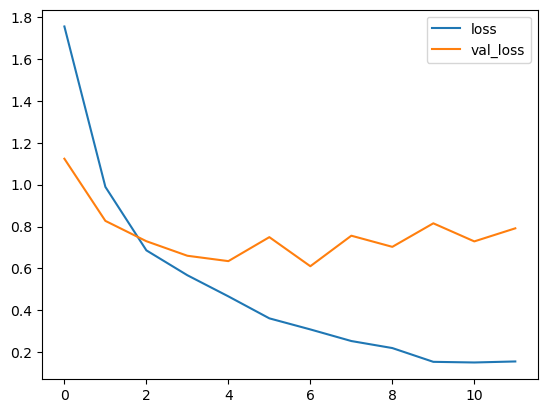

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])

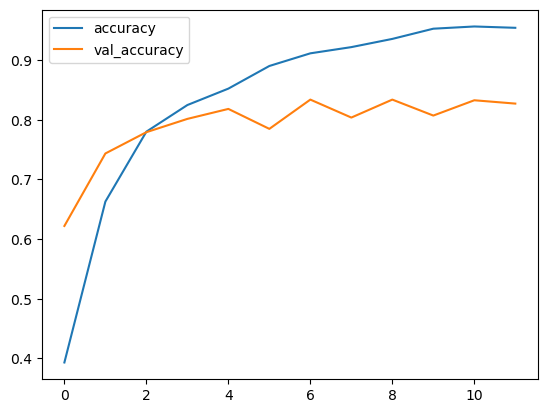

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])

We can see that this model reached a min loss at epoch 7 with an accuracy of 83%, a decent improvement over our reference implementation. Let's also evaluate its performance against the test dataset:

In [ ]:
predictions = model.predict(X_test)

predictions = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)

confusion_matrix = confusion_matrix(true_labels, predictions)

29/29 [==============================] - 1s 3ms/step


In [ ]:
print(classification_report(true_labels, predictions))

              precision    recall  f1-score   support

           0       0.81      0.87      0.84        90
           1       0.79      0.80      0.80        87
           2       0.71      0.88      0.78       107
           3       0.89      0.80      0.84        88
           4       0.89      0.94      0.92        81
           5       0.81      0.87      0.84       115
           6       0.96      0.88      0.92        75
           7       0.81      0.62      0.70        91
           8       0.81      0.81      0.81        74
           9       0.91      0.82      0.86        89

    accuracy                           0.83       897
   macro avg       0.84      0.83      0.83       897
weighted avg       0.83      0.83      0.83       897



In [ ]:
print(confusion_matrix)

[[ 78   1   1   5   1   0   0   1   3   0]
 [  3  70   2   1   2   1   1   2   1   4]
 [  2   1  94   0   0   4   0   3   2   1]
 [  5   2   8  70   1   0   0   0   2   0]
 [  0   0   1   1  76   0   0   3   0   0]
 [  0   4   7   0   0 100   0   1   2   1]
 [  0   1   1   0   0   7  66   0   0   0]
 [  3  10   5   1   2   8   2  56   3   1]
 [  3   0   7   1   1   2   0   0  60   0]
 [  2   0   7   0   2   1   0   3   1  73]]


In [ ]:
confusion_matrix=a

<AxesSubplot:>

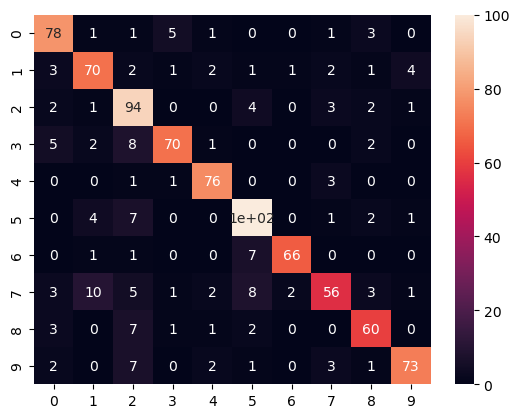

In [ ]:
import seaborn as sns
sns.heatmap(confusion_matrix, annot=True)

## Transformers

Next up we will use pretrained transformer-based models from huggingface's transformers library. While the library supports tensorflow, it is much easier to find material for pytorch applications so we will switch our backend for this part.

Let's begin by defining a few helper functions:

In [ ]:
def tokenize(sentence, tokenizer):
    tokenized_sentence = tokenizer.encode(sentence, add_special_tokens=True, max_length=max_sequence_length, padding='max_length', truncation=True)
    return tokenized_sentence

def tokenize_batch(sentences, tokenizer):
    tokenized_sentences = [tokenize(sentence, tokenizer) for sentence in sentences]
    return torch.tensor(tokenized_sentences)

In [ ]:
def get_dataloader(X, y, tokenizer, batch_size=128):
    X_tensor = tokenize_batch(X, tokenizer)
    y_tensor = torch.tensor(y)
    dataset = TensorDataset(X_tensor, y_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

In [ ]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


In [ ]:
import time
import datetime

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
def predict(sentence, tokenizer):
    tokenized_sentence = tokenize(sentence, tokenizer)
    tokenized_sentence = torch.tensor(tokenized_sentence).unsqueeze(0).to(device)
    attention_mask = (tokenized_sentence != 0).int().to(device)
    with torch.no_grad():
        logits = model(tokenized_sentence, attention_mask=attention_mask)['logits']
    logits = logits.detach().cpu().numpy()

    return logits

def predict_batch(sentences, tokenizer):
    tokenized_sentences = tokenize_batch(sentences, tokenizer).to(device)
    attention_mask = (tokenized_sentences != 0).int().to(device)
    with torch.no_grad():
        logits = model(tokenized_sentences, attention_mask=attention_mask)['logits']
    logits = logits.detach().cpu().numpy()

    return logits

In [ ]:
def train(model, dataloader, optimizer, scheduler):
    total_loss = 0
    total_accuracy = 0
    total_samples = 0

    model.train()

    for batch in dataloader:
        batch_input_vector = batch[0].to(device)
        batch_labels = batch[1].to(device)
        batch_attention_mask = (batch_input_vector != 0).int().to(device)

        model.zero_grad()
        out = model(batch_input_vector, labels=batch_labels, attention_mask=batch_attention_mask)

        loss = out['loss']
        logits = out['logits']

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        logits = logits.detach().cpu().numpy()
        label_ids = batch_labels.cpu().numpy()

        total_loss += len(batch_input_vector)*loss.item()
        total_accuracy += len(batch_input_vector)*flat_accuracy(logits, label_ids)
        total_samples += len(batch_input_vector)

    avg_loss = total_loss / total_samples
    avg_accuracy = total_accuracy / total_samples

    return (avg_loss, avg_accuracy)

In [ ]:
def eval(model, dataloader):
    total_loss = 0
    total_accuracy = 0
    total_samples = 0

    model.eval()

    for batch in dataloader:
        batch_input_vector = batch[0].to(device)
        batch_labels = batch[1].to(device)
        batch_attention_mask = (batch_input_vector != 0).int().to(device)

        with torch.no_grad():
            out = model(batch_input_vector, labels=batch_labels, attention_mask=batch_attention_mask)

        loss = out['loss']
        logits = out['logits']

        logits = logits.detach().cpu().numpy()
        label_ids = batch_labels.cpu().numpy()

        total_loss += len(batch_input_vector)*loss.item()
        total_accuracy += len(batch_input_vector)*flat_accuracy(logits, label_ids)
        total_samples += len(batch_input_vector)

    avg_loss = total_loss / total_samples
    avg_accuracy = total_accuracy / total_samples

    return (avg_loss, avg_accuracy)

### Bert reference

As before, we start by manually implementing a reference model before performing a search for fine-tuned hyperparameters:

In [ ]:
model_checkpoint='bert-base-uncased'
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)
tokenizer=AutoTokenizer.from_pretrained(model_checkpoint)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

The learning rate and epsilon values were manually tuned through trial and error:

In [ ]:
optimizer = AdamW(model.parameters(), lr=1e-4, eps=1e-8)

/home/viktor/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
train_dataloader=get_dataloader(X_train, y_train_int, tokenizer)
val_dataloader=get_dataloader(X_val, y_val_int, tokenizer)
test_dataloader=get_dataloader(X_test, y_test_int, tokenizer)

In [ ]:
epochs = 10
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

In [ ]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
total_t0 = time.time()
history = dict()
history['train_loss'] = []
history['train_accuracy'] = []
history['val_loss'] = []
history['val_accuracy'] = []
min_loss = float('inf')
epochs_with_no_improvement = 0

for epoch_i in range(epochs):
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...', end='')
    t0 = time.time()

    avg_train_loss, avg_train_accuracy = train(model, train_dataloader, optimizer, scheduler)

    history['train_loss'].append(avg_train_loss)
    history['train_accuracy'].append(avg_train_accuracy)

    training_time = format_time(time.time() - t0)
    print('\rTraining\tLoss: {0:.2f}\tAccuracy: {1:.2f}\t\tTime: {2:}s'.format(
        avg_train_loss, avg_train_accuracy, training_time))

    print('Validation...', end='')
    t0 = time.time()

    avg_val_loss, avg_val_accuracy = eval(model, val_dataloader)

    history['val_loss'].append(avg_val_loss)
    history['val_accuracy'].append(avg_val_accuracy)

    validation_time = format_time(time.time() - t0)
    print('\rValidation\tLoss: {0:.2f}\tAccuracy: {1:.2f}\t\tTime: {2:}s'.format(
        avg_val_loss, avg_val_accuracy, validation_time))

    # early stopping
    if(avg_val_loss < min_loss):
        min_loss = avg_val_loss
        epochs_with_no_improvement = 0

    if(epochs_with_no_improvement >= early_stopping_patience):
        break

print('\nTotal training took {:} (h:mm:ss)'.format(format_time(time.time()-total_t0)))

model.save_pretrained('model')
tokenizer.save_pretrained('model')

======== Epoch 1 / 10 ========
Training	Loss: 1.68	Accuracy: 0.52		Time: 0:00:08s
Validation	Loss: 0.89	Accuracy: 0.79		Time: 0:00:01s
======== Epoch 2 / 10 ========
Training	Loss: 0.59	Accuracy: 0.85		Time: 0:00:08s
Validation	Loss: 0.45	Accuracy: 0.88		Time: 0:00:01s
======== Epoch 3 / 10 ========
Training	Loss: 0.24	Accuracy: 0.94		Time: 0:00:08s
Validation	Loss: 0.39	Accuracy: 0.90		Time: 0:00:01s
======== Epoch 4 / 10 ========
Training	Loss: 0.12	Accuracy: 0.97		Time: 0:00:08s
Validation	Loss: 0.39	Accuracy: 0.90		Time: 0:00:01s
======== Epoch 5 / 10 ========
Training	Loss: 0.06	Accuracy: 0.99		Time: 0:00:08s
Validation	Loss: 0.41	Accuracy: 0.90		Time: 0:00:01s
======== Epoch 6 / 10 ========
Training	Loss: 0.03	Accuracy: 0.99		Time: 0:00:08s
Validation	Loss: 0.38	Accuracy: 0.90		Time: 0:00:01s
======== Epoch 7 / 10 ========
Training	Loss: 0.02	Accuracy: 1.00		Time: 0:00:08s
Validation	Loss: 0.43	Accuracy: 0.91		Time: 0:00:01s
======== Epoch 8 / 10 ========
Training	Loss: 0.01	Accu

('model/tokenizer_config.json',
 'model/special_tokens_map.json',
 'model/vocab.txt',
 'model/added_tokens.json',
 'model/tokenizer.json')

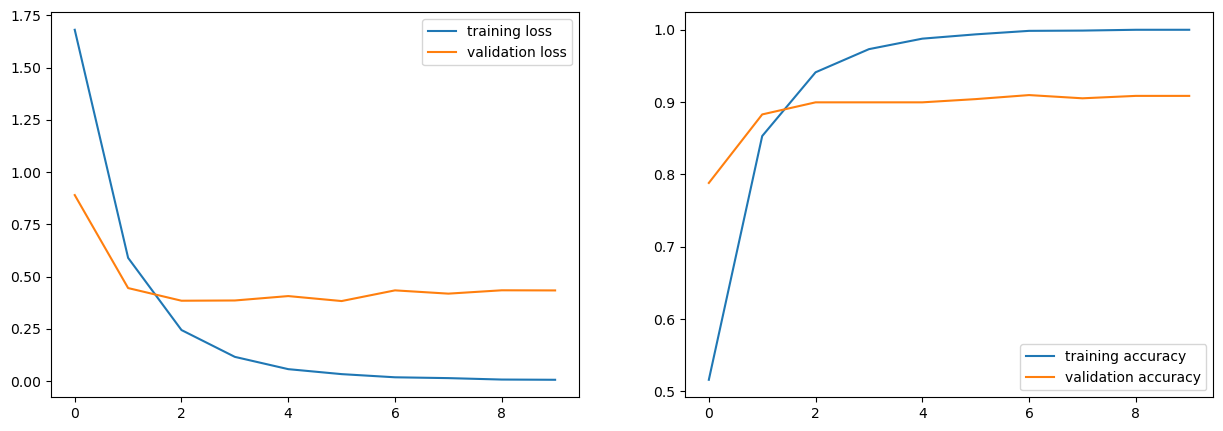

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(history['train_loss'])
plt.plot(history['val_loss'])
plt.legend(['training loss', 'validation loss'])
plt.subplot(122)
plt.plot(history['train_accuracy'])
plt.plot(history['val_accuracy'])
plt.legend(['training accuracy', 'validation accuracy'])

We can see that Bert quickly converges and reaches an accuracy of 90%.

### Tuning

We will perform a simple grid search to find the best combination of hyperparameters for each model.

In [ ]:
hyperparameters = \
{
    'checkpoint': ['bert-base-uncased', 'roberta-base', 'distilbert-base-uncased'],
    'learning_rate': [1e-5, 5e-5, 1e-4, 5e-4],
    'epsilon': [1e-6, 1e-7, 1e-8],
    'batch_size': [64, 128],
}

Create a list of all hyperparameter value permutations:

In [ ]:
import itertools

keys = list(hyperparameters.keys())
grid = [dict(zip(keys, values)) for values in itertools.product(*hyperparameters.values())]
print(len(grid))
print(grid[0])
print('...')
print(grid[-1])

72
{'checkpoint': 'bert-base-uncased', 'learning_rate': 1e-05, 'epsilon': 1e-06, 'batch_size': 64}
...
{'checkpoint': 'distilbert-base-uncased', 'learning_rate': 0.0005, 'epsilon': 1e-08, 'batch_size': 128}


In [ ]:
def model_fit(hp, epochs=5, early_stopping_patience=3, early_stopping_epsilon=0.05, verbose=True):
    model = AutoModelForSequenceClassification.from_pretrained(hp['checkpoint'], num_labels=num_labels)
    tokenizer=AutoTokenizer.from_pretrained(hp['checkpoint'])

    optimizer = AdamW(model.parameters(), lr=hp['learning_rate'], eps=hp['epsilon'])

    train_dataloader=get_dataloader(X_train, y_train_int, tokenizer, batch_size=hp['batch_size'])
    val_dataloader=get_dataloader(X_val, y_val_int, tokenizer, batch_size=hp['batch_size'])

    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    model.to(device)

    total_t0 = time.time()
    history = dict()
    history['train_loss'] = []
    history['train_accuracy'] = []
    history['val_loss'] = []
    history['val_accuracy'] = []
    min_loss = float('inf')
    epochs_with_no_improvement = 0

    for epoch_i in range(epochs):
        if verbose:
            print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
            print('Training...', end='')
            t0 = time.time()

        avg_train_loss, avg_train_accuracy = train(model, train_dataloader, optimizer, scheduler)

        history['train_loss'].append(avg_train_loss)
        history['train_accuracy'].append(avg_train_accuracy)

        if verbose:
            training_time = format_time(time.time() - t0)
            print('\rTraining\tLoss: {0:.2f}\tAccuracy: {1:.2f}\t\tTime: {2:}s'.format(
                avg_train_loss, avg_train_accuracy, training_time))
            print('Validation...', end='')
            t0 = time.time()

        avg_val_loss, avg_val_accuracy = eval(model, val_dataloader)

        history['val_loss'].append(avg_val_loss)
        history['val_accuracy'].append(avg_val_accuracy)

        if verbose:
            validation_time = format_time(time.time() - t0)
            print('\rValidation\tLoss: {0:.2f}\tAccuracy: {1:.2f}\t\tTime: {2:}s'.format(
                avg_val_loss, avg_val_accuracy, validation_time))

        # early stopping
        epochs_with_no_improvement+=1

        if(avg_val_loss <= min_loss + early_stopping_epsilon):
            min_loss = min(avg_val_loss, min_loss)
            epochs_with_no_improvement = 0

        if(epochs_with_no_improvement >= early_stopping_patience):
            break

    if verbose:
        print('\nTotal model training took {:} (h:mm:ss)'.format(format_time(time.time()-total_t0)))

    return history

Due to some memory issues it is necessary to clear the VRAM after each model training.

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

Perform the grid search:

In [ ]:
%%time

epochs = 4
early_stopping_patience = 1
early_stopping_epsilon = 0.05

results = dict()

for hp in grid:
    print(hp)

    model_hp = str(hp)
    results[model_hp] = model_fit(hp)

    gc.collect()
    torch.cuda.empty_cache()


{'checkpoint': 'bert-base-uncased', 'learning_rate': 1e-05, 'epsilon': 1e-06, 'batch_size': 64}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

======== Epoch 1 / 5 ========
Training	Loss: 2.24	Accuracy: 0.18		Time: 0:00:10s
Validation	Loss: 2.05	Accuracy: 0.31		Time: 0:00:01s
======== Epoch 2 / 5 ========
Training	Loss: 1.97	Accuracy: 0.37		Time: 0:00:09s
Validation	Loss: 1.81	Accuracy: 0.55		Time: 0:00:01s
======== Epoch 3 / 5 ========
Training	Loss: 1.76	Accuracy: 0.53		Time: 0:00:09s
Validation	Loss: 1.64	Accuracy: 0.63		Time: 0:00:01s
======== Epoch 4 / 5 ========
Training	Loss: 1.62	Accuracy: 0.63		Time: 0:00:09s
Validation	Loss: 1.52	Accuracy: 0.68		Time: 0:00:01s
======== Epoch 5 / 5 ========
Training	Loss: 1.53	Accuracy: 0.67		Time: 0:00:09s
Validation	Loss: 1.48	Accuracy: 0.69		Time: 0:00:01s

Total model training took 0:00:51 (h:mm:ss)
{'checkpoint': 'bert-base-uncased', 'learning_rate': 1e-05, 'epsilon': 1e-06, 'batch_size': 128}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

======== Epoch 1 / 5 ========
Training	Loss: 2.26	Accuracy: 0.14		Time: 0:00:07s
Validation	Loss: 2.18	Accuracy: 0.20		Time: 0:00:01s
======== Epoch 2 / 5 ========
Training	Loss: 2.13	Accuracy: 0.23		Time: 0:00:07s
Validation	Loss: 2.06	Accuracy: 0.30		Time: 0:00:01s
======== Epoch 3 / 5 ========
Training	Loss: 2.02	Accuracy: 0.31		Time: 0:00:07s
Validation	Loss: 1.94	Accuracy: 0.41		Time: 0:00:01s
======== Epoch 4 / 5 ========
Training	Loss: 1.93	Accuracy: 0.38		Time: 0:00:07s
Validation	Loss: 1.87	Accuracy: 0.47		Time: 0:00:01s
======== Epoch 5 / 5 ========
Training	Loss: 1.87	Accuracy: 0.44		Time: 0:00:07s
Validation	Loss: 1.84	Accuracy: 0.49		Time: 0:00:01s

Total model training took 0:00:41 (h:mm:ss)
{'checkpoint': 'bert-base-uncased', 'learning_rate': 1e-05, 'epsilon': 1e-07, 'batch_size': 64}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

======== Epoch 1 / 5 ========
Training	Loss: 2.25	Accuracy: 0.17		Time: 0:00:09s
Validation	Loss: 2.09	Accuracy: 0.28		Time: 0:00:01s
======== Epoch 2 / 5 ========
Training	Loss: 1.96	Accuracy: 0.40		Time: 0:00:09s
Validation	Loss: 1.77	Accuracy: 0.53		Time: 0:00:01s
======== Epoch 3 / 5 ========
Training	Loss: 1.67	Accuracy: 0.61		Time: 0:00:09s
Validation	Loss: 1.53	Accuracy: 0.64		Time: 0:00:01s
======== Epoch 4 / 5 ========
Training	Loss: 1.49	Accuracy: 0.70		Time: 0:00:09s
Validation	Loss: 1.39	Accuracy: 0.70		Time: 0:00:01s
======== Epoch 5 / 5 ========
Training	Loss: 1.39	Accuracy: 0.75		Time: 0:00:09s
Validation	Loss: 1.34	Accuracy: 0.71		Time: 0:00:01s

Total model training took 0:00:49 (h:mm:ss)
{'checkpoint': 'bert-base-uncased', 'learning_rate': 1e-05, 'epsilon': 1e-07, 'batch_size': 128}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

======== Epoch 1 / 5 ========
Training	Loss: 2.28	Accuracy: 0.15		Time: 0:00:07s
Validation	Loss: 2.15	Accuracy: 0.26		Time: 0:00:01s
======== Epoch 2 / 5 ========
Training	Loss: 2.10	Accuracy: 0.31		Time: 0:00:07s
Validation	Loss: 1.97	Accuracy: 0.46		Time: 0:00:01s
======== Epoch 3 / 5 ========
Training	Loss: 1.95	Accuracy: 0.46		Time: 0:00:07s
Validation	Loss: 1.85	Accuracy: 0.58		Time: 0:00:01s
======== Epoch 4 / 5 ========
Training	Loss: 1.85	Accuracy: 0.53		Time: 0:00:07s
Validation	Loss: 1.77	Accuracy: 0.63		Time: 0:00:01s
======== Epoch 5 / 5 ========
Training	Loss: 1.79	Accuracy: 0.57		Time: 0:00:07s
Validation	Loss: 1.74	Accuracy: 0.66		Time: 0:00:01s

Total model training took 0:00:41 (h:mm:ss)
{'checkpoint': 'bert-base-uncased', 'learning_rate': 1e-05, 'epsilon': 1e-08, 'batch_size': 64}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

======== Epoch 1 / 5 ========
Training	Loss: 2.21	Accuracy: 0.22		Time: 0:00:09s
Validation	Loss: 2.08	Accuracy: 0.32		Time: 0:00:01s
======== Epoch 2 / 5 ========
Training	Loss: 1.95	Accuracy: 0.48		Time: 0:00:09s
Validation	Loss: 1.77	Accuracy: 0.59		Time: 0:00:01s
======== Epoch 3 / 5 ========
Training	Loss: 1.66	Accuracy: 0.65		Time: 0:00:09s
Validation	Loss: 1.51	Accuracy: 0.69		Time: 0:00:01s
======== Epoch 4 / 5 ========
Training	Loss: 1.45	Accuracy: 0.73		Time: 0:00:09s
Validation	Loss: 1.35	Accuracy: 0.74		Time: 0:00:01s
======== Epoch 5 / 5 ========
Training	Loss: 1.34	Accuracy: 0.76		Time: 0:00:09s
Validation	Loss: 1.30	Accuracy: 0.75		Time: 0:00:01s

Total model training took 0:00:49 (h:mm:ss)
{'checkpoint': 'bert-base-uncased', 'learning_rate': 1e-05, 'epsilon': 1e-08, 'batch_size': 128}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

======== Epoch 1 / 5 ========
Training	Loss: 2.27	Accuracy: 0.14		Time: 0:00:07s
Validation	Loss: 2.18	Accuracy: 0.27		Time: 0:00:01s
======== Epoch 2 / 5 ========
Training	Loss: 2.13	Accuracy: 0.31		Time: 0:00:07s
Validation	Loss: 2.00	Accuracy: 0.44		Time: 0:00:01s
======== Epoch 3 / 5 ========
Training	Loss: 1.98	Accuracy: 0.44		Time: 0:00:07s
Validation	Loss: 1.86	Accuracy: 0.60		Time: 0:00:01s
======== Epoch 4 / 5 ========
Training	Loss: 1.85	Accuracy: 0.56		Time: 0:00:07s
Validation	Loss: 1.77	Accuracy: 0.65		Time: 0:00:01s
======== Epoch 5 / 5 ========
Training	Loss: 1.79	Accuracy: 0.59		Time: 0:00:07s
Validation	Loss: 1.73	Accuracy: 0.66		Time: 0:00:01s

Total model training took 0:00:41 (h:mm:ss)
{'checkpoint': 'bert-base-uncased', 'learning_rate': 5e-05, 'epsilon': 1e-06, 'batch_size': 64}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

======== Epoch 1 / 5 ========
Training	Loss: 1.93	Accuracy: 0.38		Time: 0:00:09s
Validation	Loss: 1.25	Accuracy: 0.69		Time: 0:00:01s
======== Epoch 2 / 5 ========
Training	Loss: 0.86	Accuracy: 0.81		Time: 0:00:09s
Validation	Loss: 0.63	Accuracy: 0.83		Time: 0:00:01s
======== Epoch 3 / 5 ========
Training	Loss: 0.41	Accuracy: 0.90		Time: 0:00:09s
Validation	Loss: 0.45	Accuracy: 0.87		Time: 0:00:01s
======== Epoch 4 / 5 ========
Training	Loss: 0.22	Accuracy: 0.96		Time: 0:00:09s
Validation	Loss: 0.40	Accuracy: 0.88		Time: 0:00:01s
======== Epoch 5 / 5 ========
Training	Loss: 0.14	Accuracy: 0.98		Time: 0:00:09s
Validation	Loss: 0.39	Accuracy: 0.88		Time: 0:00:01s

Total model training took 0:00:49 (h:mm:ss)
{'checkpoint': 'bert-base-uncased', 'learning_rate': 5e-05, 'epsilon': 1e-06, 'batch_size': 128}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

======== Epoch 1 / 5 ========
Training	Loss: 2.08	Accuracy: 0.32		Time: 0:00:07s
Validation	Loss: 1.66	Accuracy: 0.64		Time: 0:00:01s
======== Epoch 2 / 5 ========
Training	Loss: 1.35	Accuracy: 0.71		Time: 0:00:07s
Validation	Loss: 0.99	Accuracy: 0.79		Time: 0:00:01s
======== Epoch 3 / 5 ========
Training	Loss: 0.80	Accuracy: 0.84		Time: 0:00:07s
Validation	Loss: 0.69	Accuracy: 0.85		Time: 0:00:01s
======== Epoch 4 / 5 ========
Training	Loss: 0.53	Accuracy: 0.91		Time: 0:00:07s
Validation	Loss: 0.56	Accuracy: 0.87		Time: 0:00:01s
======== Epoch 5 / 5 ========
Training	Loss: 0.42	Accuracy: 0.93		Time: 0:00:07s
Validation	Loss: 0.53	Accuracy: 0.87		Time: 0:00:01s

Total model training took 0:00:41 (h:mm:ss)
{'checkpoint': 'bert-base-uncased', 'learning_rate': 5e-05, 'epsilon': 1e-07, 'batch_size': 64}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

======== Epoch 1 / 5 ========
Training	Loss: 1.94	Accuracy: 0.36		Time: 0:00:09s
Validation	Loss: 1.23	Accuracy: 0.72		Time: 0:00:01s
======== Epoch 2 / 5 ========
Training	Loss: 0.81	Accuracy: 0.82		Time: 0:00:09s
Validation	Loss: 0.55	Accuracy: 0.86		Time: 0:00:01s
======== Epoch 3 / 5 ========
Training	Loss: 0.35	Accuracy: 0.93		Time: 0:00:09s
Validation	Loss: 0.40	Accuracy: 0.89		Time: 0:00:01s
======== Epoch 4 / 5 ========
Training	Loss: 0.19	Accuracy: 0.96		Time: 0:00:09s
Validation	Loss: 0.39	Accuracy: 0.89		Time: 0:00:01s
======== Epoch 5 / 5 ========
Training	Loss: 0.12	Accuracy: 0.98		Time: 0:00:09s
Validation	Loss: 0.38	Accuracy: 0.90		Time: 0:00:01s

Total model training took 0:00:49 (h:mm:ss)
{'checkpoint': 'bert-base-uncased', 'learning_rate': 5e-05, 'epsilon': 1e-07, 'batch_size': 128}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

======== Epoch 1 / 5 ========
Training	Loss: 2.04	Accuracy: 0.34		Time: 0:00:07s
Validation	Loss: 1.59	Accuracy: 0.66		Time: 0:00:01s
======== Epoch 2 / 5 ========
Training	Loss: 1.23	Accuracy: 0.76		Time: 0:00:07s
Validation	Loss: 0.88	Accuracy: 0.82		Time: 0:00:01s
======== Epoch 3 / 5 ========
Training	Loss: 0.68	Accuracy: 0.89		Time: 0:00:07s
Validation	Loss: 0.59	Accuracy: 0.87		Time: 0:00:01s
======== Epoch 4 / 5 ========
Training	Loss: 0.44	Accuracy: 0.93		Time: 0:00:07s
Validation	Loss: 0.49	Accuracy: 0.89		Time: 0:00:01s
======== Epoch 5 / 5 ========
Training	Loss: 0.33	Accuracy: 0.96		Time: 0:00:07s
Validation	Loss: 0.46	Accuracy: 0.89		Time: 0:00:01s

Total model training took 0:00:41 (h:mm:ss)
{'checkpoint': 'bert-base-uncased', 'learning_rate': 5e-05, 'epsilon': 1e-08, 'batch_size': 64}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

======== Epoch 1 / 5 ========
Training	Loss: 1.83	Accuracy: 0.45		Time: 0:00:09s
Validation	Loss: 1.05	Accuracy: 0.77		Time: 0:00:01s
======== Epoch 2 / 5 ========
Training	Loss: 0.69	Accuracy: 0.86		Time: 0:00:09s
Validation	Loss: 0.50	Accuracy: 0.88		Time: 0:00:01s
======== Epoch 3 / 5 ========
Training	Loss: 0.31	Accuracy: 0.93		Time: 0:00:09s
Validation	Loss: 0.38	Accuracy: 0.90		Time: 0:00:01s
======== Epoch 4 / 5 ========
Training	Loss: 0.16	Accuracy: 0.97		Time: 0:00:09s
Validation	Loss: 0.36	Accuracy: 0.91		Time: 0:00:01s
======== Epoch 5 / 5 ========
Training	Loss: 0.10	Accuracy: 0.98		Time: 0:00:09s
Validation	Loss: 0.36	Accuracy: 0.91		Time: 0:00:01s

Total model training took 0:00:49 (h:mm:ss)
{'checkpoint': 'bert-base-uncased', 'learning_rate': 5e-05, 'epsilon': 1e-08, 'batch_size': 128}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

======== Epoch 1 / 5 ========
Training	Loss: 2.10	Accuracy: 0.31		Time: 0:00:07s
Validation	Loss: 1.63	Accuracy: 0.62		Time: 0:00:01s
======== Epoch 2 / 5 ========
Training	Loss: 1.25	Accuracy: 0.72		Time: 0:00:07s
Validation	Loss: 0.90	Accuracy: 0.77		Time: 0:00:01s
======== Epoch 3 / 5 ========
Training	Loss: 0.70	Accuracy: 0.86		Time: 0:00:07s
Validation	Loss: 0.63	Accuracy: 0.84		Time: 0:00:01s
======== Epoch 4 / 5 ========
Training	Loss: 0.45	Accuracy: 0.92		Time: 0:00:07s
Validation	Loss: 0.53	Accuracy: 0.87		Time: 0:00:01s
======== Epoch 5 / 5 ========
Training	Loss: 0.34	Accuracy: 0.94		Time: 0:00:07s
Validation	Loss: 0.49	Accuracy: 0.87		Time: 0:00:01s

Total model training took 0:00:41 (h:mm:ss)
{'checkpoint': 'bert-base-uncased', 'learning_rate': 0.0001, 'epsilon': 1e-06, 'batch_size': 64}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

======== Epoch 1 / 5 ========
Training	Loss: 1.61	Accuracy: 0.50		Time: 0:00:09s
Validation	Loss: 0.74	Accuracy: 0.82		Time: 0:00:01s
======== Epoch 2 / 5 ========
Training	Loss: 0.48	Accuracy: 0.88		Time: 0:00:09s
Validation	Loss: 0.44	Accuracy: 0.88		Time: 0:00:01s
======== Epoch 3 / 5 ========
Training	Loss: 0.19	Accuracy: 0.95		Time: 0:00:09s
Validation	Loss: 0.38	Accuracy: 0.90		Time: 0:00:01s
======== Epoch 4 / 5 ========
Training	Loss: 0.08	Accuracy: 0.99		Time: 0:00:09s
Validation	Loss: 0.41	Accuracy: 0.90		Time: 0:00:01s
======== Epoch 5 / 5 ========
Training	Loss: 0.04	Accuracy: 0.99		Time: 0:00:09s
Validation	Loss: 0.41	Accuracy: 0.90		Time: 0:00:01s

Total model training took 0:00:49 (h:mm:ss)
{'checkpoint': 'bert-base-uncased', 'learning_rate': 0.0001, 'epsilon': 1e-06, 'batch_size': 128}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

======== Epoch 1 / 5 ========
Training	Loss: 1.89	Accuracy: 0.40		Time: 0:00:07s
Validation	Loss: 1.10	Accuracy: 0.76		Time: 0:00:01s
======== Epoch 2 / 5 ========
Training	Loss: 0.72	Accuracy: 0.84		Time: 0:00:07s
Validation	Loss: 0.53	Accuracy: 0.86		Time: 0:00:01s
======== Epoch 3 / 5 ========
Training	Loss: 0.30	Accuracy: 0.93		Time: 0:00:07s
Validation	Loss: 0.44	Accuracy: 0.88		Time: 0:00:01s
======== Epoch 4 / 5 ========
Training	Loss: 0.15	Accuracy: 0.97		Time: 0:00:07s
Validation	Loss: 0.38	Accuracy: 0.90		Time: 0:00:01s
======== Epoch 5 / 5 ========
Training	Loss: 0.09	Accuracy: 0.99		Time: 0:00:07s
Validation	Loss: 0.37	Accuracy: 0.90		Time: 0:00:01s

Total model training took 0:00:41 (h:mm:ss)
{'checkpoint': 'bert-base-uncased', 'learning_rate': 0.0001, 'epsilon': 1e-07, 'batch_size': 64}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

======== Epoch 1 / 5 ========
Training	Loss: 1.50	Accuracy: 0.54		Time: 0:00:09s
Validation	Loss: 0.71	Accuracy: 0.82		Time: 0:00:01s
======== Epoch 2 / 5 ========
Training	Loss: 0.44	Accuracy: 0.88		Time: 0:00:09s
Validation	Loss: 0.44	Accuracy: 0.88		Time: 0:00:01s
======== Epoch 3 / 5 ========
Training	Loss: 0.18	Accuracy: 0.95		Time: 0:00:09s
Validation	Loss: 0.41	Accuracy: 0.89		Time: 0:00:01s
======== Epoch 4 / 5 ========
Training	Loss: 0.08	Accuracy: 0.98		Time: 0:00:09s
Validation	Loss: 0.39	Accuracy: 0.91		Time: 0:00:01s
======== Epoch 5 / 5 ========
Training	Loss: 0.04	Accuracy: 0.99		Time: 0:00:09s
Validation	Loss: 0.42	Accuracy: 0.90		Time: 0:00:01s

Total model training took 0:00:49 (h:mm:ss)
{'checkpoint': 'bert-base-uncased', 'learning_rate': 0.0001, 'epsilon': 1e-07, 'batch_size': 128}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

======== Epoch 1 / 5 ========
Training	Loss: 1.75	Accuracy: 0.48		Time: 0:00:07s
Validation	Loss: 0.96	Accuracy: 0.76		Time: 0:00:01s
======== Epoch 2 / 5 ========
Training	Loss: 0.66	Accuracy: 0.84		Time: 0:00:07s
Validation	Loss: 0.50	Accuracy: 0.86		Time: 0:00:01s
======== Epoch 3 / 5 ========
Training	Loss: 0.30	Accuracy: 0.93		Time: 0:00:07s
Validation	Loss: 0.39	Accuracy: 0.90		Time: 0:00:01s
======== Epoch 4 / 5 ========
Training	Loss: 0.15	Accuracy: 0.97		Time: 0:00:07s
Validation	Loss: 0.37	Accuracy: 0.91		Time: 0:00:01s
======== Epoch 5 / 5 ========
Training	Loss: 0.09	Accuracy: 0.98		Time: 0:00:07s
Validation	Loss: 0.35	Accuracy: 0.91		Time: 0:00:01s

Total model training took 0:00:41 (h:mm:ss)
{'checkpoint': 'bert-base-uncased', 'learning_rate': 0.0001, 'epsilon': 1e-08, 'batch_size': 64}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

======== Epoch 1 / 5 ========
Training	Loss: 1.43	Accuracy: 0.56		Time: 0:00:09s
Validation	Loss: 0.68	Accuracy: 0.80		Time: 0:00:01s
======== Epoch 2 / 5 ========
Training	Loss: 0.45	Accuracy: 0.88		Time: 0:00:09s
Validation	Loss: 0.45	Accuracy: 0.88		Time: 0:00:01s
======== Epoch 3 / 5 ========
Training	Loss: 0.22	Accuracy: 0.94		Time: 0:00:09s
Validation	Loss: 0.40	Accuracy: 0.88		Time: 0:00:01s
======== Epoch 4 / 5 ========
Training	Loss: 0.09	Accuracy: 0.98		Time: 0:00:09s
Validation	Loss: 0.43	Accuracy: 0.90		Time: 0:00:01s
======== Epoch 5 / 5 ========
Training	Loss: 0.05	Accuracy: 0.99		Time: 0:00:09s
Validation	Loss: 0.42	Accuracy: 0.90		Time: 0:00:01s

Total model training took 0:00:49 (h:mm:ss)
{'checkpoint': 'bert-base-uncased', 'learning_rate': 0.0001, 'epsilon': 1e-08, 'batch_size': 128}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

======== Epoch 1 / 5 ========
Training	Loss: 1.87	Accuracy: 0.40		Time: 0:00:07s
Validation	Loss: 1.18	Accuracy: 0.69		Time: 0:00:01s
======== Epoch 2 / 5 ========
Training	Loss: 0.78	Accuracy: 0.82		Time: 0:00:07s
Validation	Loss: 0.50	Accuracy: 0.87		Time: 0:00:01s
======== Epoch 3 / 5 ========
Training	Loss: 0.31	Accuracy: 0.93		Time: 0:00:07s
Validation	Loss: 0.40	Accuracy: 0.88		Time: 0:00:01s
======== Epoch 4 / 5 ========
Training	Loss: 0.16	Accuracy: 0.97		Time: 0:00:07s
Validation	Loss: 0.38	Accuracy: 0.90		Time: 0:00:01s
======== Epoch 5 / 5 ========
Training	Loss: 0.09	Accuracy: 0.99		Time: 0:00:07s
Validation	Loss: 0.37	Accuracy: 0.90		Time: 0:00:01s

Total model training took 0:00:41 (h:mm:ss)
{'checkpoint': 'bert-base-uncased', 'learning_rate': 0.0005, 'epsilon': 1e-06, 'batch_size': 64}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

======== Epoch 1 / 5 ========
Training	Loss: 1.35	Accuracy: 0.54		Time: 0:00:09s
Validation	Loss: 0.71	Accuracy: 0.80		Time: 0:00:01s
======== Epoch 2 / 5 ========
Training	Loss: 0.58	Accuracy: 0.84		Time: 0:00:09s
Validation	Loss: 0.74	Accuracy: 0.80		Time: 0:00:01s
======== Epoch 3 / 5 ========
Training	Loss: 0.37	Accuracy: 0.91		Time: 0:00:09s
Validation	Loss: 0.48	Accuracy: 0.87		Time: 0:00:01s
======== Epoch 4 / 5 ========
Training	Loss: 0.23	Accuracy: 0.94		Time: 0:00:09s
Validation	Loss: 0.57	Accuracy: 0.87		Time: 0:00:01s
======== Epoch 5 / 5 ========
Training	Loss: 0.12	Accuracy: 0.97		Time: 0:00:09s
Validation	Loss: 0.49	Accuracy: 0.89		Time: 0:00:01s

Total model training took 0:00:49 (h:mm:ss)
{'checkpoint': 'bert-base-uncased', 'learning_rate': 0.0005, 'epsilon': 1e-06, 'batch_size': 128}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

======== Epoch 1 / 5 ========
Training	Loss: 1.88	Accuracy: 0.34		Time: 0:00:07s
Validation	Loss: 0.96	Accuracy: 0.67		Time: 0:00:01s
======== Epoch 2 / 5 ========
Training	Loss: 0.64	Accuracy: 0.81		Time: 0:00:07s
Validation	Loss: 0.56	Accuracy: 0.83		Time: 0:00:01s
======== Epoch 3 / 5 ========
Training	Loss: 0.31	Accuracy: 0.91		Time: 0:00:07s
Validation	Loss: 0.57	Accuracy: 0.85		Time: 0:00:01s
======== Epoch 4 / 5 ========
Training	Loss: 0.19	Accuracy: 0.95		Time: 0:00:07s
Validation	Loss: 0.54	Accuracy: 0.88		Time: 0:00:01s
======== Epoch 5 / 5 ========
Training	Loss: 0.09	Accuracy: 0.98		Time: 0:00:07s
Validation	Loss: 0.51	Accuracy: 0.89		Time: 0:00:01s

Total model training took 0:00:41 (h:mm:ss)
{'checkpoint': 'bert-base-uncased', 'learning_rate': 0.0005, 'epsilon': 1e-07, 'batch_size': 64}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

======== Epoch 1 / 5 ========
Training	Loss: 2.21	Accuracy: 0.18		Time: 0:00:09s
Validation	Loss: 2.15	Accuracy: 0.21		Time: 0:00:01s
======== Epoch 2 / 5 ========
Training	Loss: 2.30	Accuracy: 0.16		Time: 0:00:09s
Validation	Loss: 2.33	Accuracy: 0.13		Time: 0:00:01s
======== Epoch 3 / 5 ========
Training	Loss: 2.31	Accuracy: 0.12		Time: 0:00:09s
Validation	Loss: 2.30	Accuracy: 0.13		Time: 0:00:01s
======== Epoch 4 / 5 ========
Training	Loss: 2.30	Accuracy: 0.13		Time: 0:00:09s
Validation	Loss: 2.29	Accuracy: 0.13		Time: 0:00:01s

Total model training took 0:00:39 (h:mm:ss)
{'checkpoint': 'bert-base-uncased', 'learning_rate': 0.0005, 'epsilon': 1e-07, 'batch_size': 128}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

======== Epoch 1 / 5 ========
Training	Loss: 1.60	Accuracy: 0.45		Time: 0:00:07s
Validation	Loss: 0.94	Accuracy: 0.68		Time: 0:00:01s
======== Epoch 2 / 5 ========
Training	Loss: 0.61	Accuracy: 0.82		Time: 0:00:07s
Validation	Loss: 0.54	Accuracy: 0.84		Time: 0:00:01s
======== Epoch 3 / 5 ========
Training	Loss: 0.32	Accuracy: 0.91		Time: 0:00:07s
Validation	Loss: 0.58	Accuracy: 0.85		Time: 0:00:01s
======== Epoch 4 / 5 ========
Training	Loss: 0.21	Accuracy: 0.94		Time: 0:00:07s
Validation	Loss: 0.48	Accuracy: 0.88		Time: 0:00:01s
======== Epoch 5 / 5 ========
Training	Loss: 0.10	Accuracy: 0.98		Time: 0:00:07s
Validation	Loss: 0.48	Accuracy: 0.89		Time: 0:00:01s

Total model training took 0:00:41 (h:mm:ss)
{'checkpoint': 'bert-base-uncased', 'learning_rate': 0.0005, 'epsilon': 1e-08, 'batch_size': 64}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

======== Epoch 1 / 5 ========
Training	Loss: 1.56	Accuracy: 0.48		Time: 0:00:09s
Validation	Loss: 0.89	Accuracy: 0.73		Time: 0:00:01s
======== Epoch 2 / 5 ========
Training	Loss: 0.79	Accuracy: 0.77		Time: 0:00:09s
Validation	Loss: 0.77	Accuracy: 0.80		Time: 0:00:01s
======== Epoch 3 / 5 ========
Training	Loss: 0.57	Accuracy: 0.86		Time: 0:00:09s
Validation	Loss: 0.61	Accuracy: 0.85		Time: 0:00:01s
======== Epoch 4 / 5 ========
Training	Loss: 0.38	Accuracy: 0.91		Time: 0:00:09s
Validation	Loss: 0.55	Accuracy: 0.86		Time: 0:00:01s
======== Epoch 5 / 5 ========
Training	Loss: 0.24	Accuracy: 0.95		Time: 0:00:09s
Validation	Loss: 0.48	Accuracy: 0.88		Time: 0:00:01s

Total model training took 0:00:49 (h:mm:ss)
{'checkpoint': 'bert-base-uncased', 'learning_rate': 0.0005, 'epsilon': 1e-08, 'batch_size': 128}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

======== Epoch 1 / 5 ========
Training	Loss: 2.35	Accuracy: 0.12		Time: 0:00:07s
Validation	Loss: 2.35	Accuracy: 0.13		Time: 0:00:01s
======== Epoch 2 / 5 ========
Training	Loss: 2.33	Accuracy: 0.10		Time: 0:00:07s
Validation	Loss: 2.31	Accuracy: 0.09		Time: 0:00:01s
======== Epoch 3 / 5 ========
Training	Loss: 2.32	Accuracy: 0.10		Time: 0:00:07s
Validation	Loss: 2.31	Accuracy: 0.13		Time: 0:00:01s
======== Epoch 4 / 5 ========
Training	Loss: 2.32	Accuracy: 0.12		Time: 0:00:07s
Validation	Loss: 2.31	Accuracy: 0.10		Time: 0:00:01s
======== Epoch 5 / 5 ========
Training	Loss: 2.31	Accuracy: 0.11		Time: 0:00:07s
Validation	Loss: 2.29	Accuracy: 0.13		Time: 0:00:01s

Total model training took 0:00:41 (h:mm:ss)
{'checkpoint': 'roberta-base', 'learning_rate': 1e-05, 'epsilon': 1e-06, 'batch_size': 64}


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

======== Epoch 1 / 5 ========
Training	Loss: 2.30	Accuracy: 0.13		Time: 0:00:09s
Validation	Loss: 2.28	Accuracy: 0.14		Time: 0:00:01s
======== Epoch 2 / 5 ========
Training	Loss: 2.26	Accuracy: 0.16		Time: 0:00:09s
Validation	Loss: 2.20	Accuracy: 0.16		Time: 0:00:01s
======== Epoch 3 / 5 ========
Training	Loss: 2.16	Accuracy: 0.21		Time: 0:00:09s
Validation	Loss: 2.06	Accuracy: 0.27		Time: 0:00:01s
======== Epoch 4 / 5 ========
Training	Loss: 2.00	Accuracy: 0.31		Time: 0:00:09s
Validation	Loss: 1.87	Accuracy: 0.42		Time: 0:00:01s
======== Epoch 5 / 5 ========
Training	Loss: 1.88	Accuracy: 0.39		Time: 0:00:09s
Validation	Loss: 1.79	Accuracy: 0.46		Time: 0:00:01s

Total model training took 0:00:51 (h:mm:ss)
{'checkpoint': 'roberta-base', 'learning_rate': 1e-05, 'epsilon': 1e-06, 'batch_size': 128}


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

======== Epoch 1 / 5 ========
Training	Loss: 2.31	Accuracy: 0.11		Time: 0:00:08s
Validation	Loss: 2.30	Accuracy: 0.11		Time: 0:00:01s
======== Epoch 2 / 5 ========
Training	Loss: 2.29	Accuracy: 0.14		Time: 0:00:08s
Validation	Loss: 2.28	Accuracy: 0.18		Time: 0:00:01s
======== Epoch 3 / 5 ========
Training	Loss: 2.27	Accuracy: 0.18		Time: 0:00:08s
Validation	Loss: 2.24	Accuracy: 0.18		Time: 0:00:01s
======== Epoch 4 / 5 ========
Training	Loss: 2.23	Accuracy: 0.20		Time: 0:00:08s
Validation	Loss: 2.19	Accuracy: 0.22		Time: 0:00:01s
======== Epoch 5 / 5 ========
Training	Loss: 2.19	Accuracy: 0.22		Time: 0:00:08s
Validation	Loss: 2.16	Accuracy: 0.23		Time: 0:00:01s

Total model training took 0:00:42 (h:mm:ss)
{'checkpoint': 'roberta-base', 'learning_rate': 1e-05, 'epsilon': 1e-07, 'batch_size': 64}


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

======== Epoch 1 / 5 ========
Training	Loss: 2.30	Accuracy: 0.11		Time: 0:00:09s
Validation	Loss: 2.28	Accuracy: 0.13		Time: 0:00:01s
======== Epoch 2 / 5 ========
Training	Loss: 2.27	Accuracy: 0.14		Time: 0:00:09s
Validation	Loss: 2.22	Accuracy: 0.18		Time: 0:00:01s
======== Epoch 3 / 5 ========
Training	Loss: 2.20	Accuracy: 0.19		Time: 0:00:09s
Validation	Loss: 2.11	Accuracy: 0.23		Time: 0:00:01s
======== Epoch 4 / 5 ========
Training	Loss: 2.09	Accuracy: 0.24		Time: 0:00:09s
Validation	Loss: 2.01	Accuracy: 0.28		Time: 0:00:01s
======== Epoch 5 / 5 ========
Training	Loss: 2.02	Accuracy: 0.28		Time: 0:00:09s
Validation	Loss: 1.97	Accuracy: 0.31		Time: 0:00:01s

Total model training took 0:00:51 (h:mm:ss)
{'checkpoint': 'roberta-base', 'learning_rate': 1e-05, 'epsilon': 1e-07, 'batch_size': 128}


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

======== Epoch 1 / 5 ========
Training	Loss: 2.30	Accuracy: 0.13		Time: 0:00:08s
Validation	Loss: 2.29	Accuracy: 0.14		Time: 0:00:01s
======== Epoch 2 / 5 ========
Training	Loss: 2.28	Accuracy: 0.15		Time: 0:00:07s
Validation	Loss: 2.26	Accuracy: 0.19		Time: 0:00:01s
======== Epoch 3 / 5 ========
Training	Loss: 2.25	Accuracy: 0.18		Time: 0:00:07s
Validation	Loss: 2.23	Accuracy: 0.18		Time: 0:00:01s
======== Epoch 4 / 5 ========
Training	Loss: 2.22	Accuracy: 0.20		Time: 0:00:08s
Validation	Loss: 2.19	Accuracy: 0.22		Time: 0:00:01s
======== Epoch 5 / 5 ========
Training	Loss: 2.19	Accuracy: 0.22		Time: 0:00:08s
Validation	Loss: 2.16	Accuracy: 0.23		Time: 0:00:01s

Total model training took 0:00:42 (h:mm:ss)
{'checkpoint': 'roberta-base', 'learning_rate': 1e-05, 'epsilon': 1e-08, 'batch_size': 64}


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

======== Epoch 1 / 5 ========
Training	Loss: 2.29	Accuracy: 0.14		Time: 0:00:09s
Validation	Loss: 2.24	Accuracy: 0.21		Time: 0:00:01s
======== Epoch 2 / 5 ========
Training	Loss: 2.18	Accuracy: 0.23		Time: 0:00:09s
Validation	Loss: 2.02	Accuracy: 0.26		Time: 0:00:01s
======== Epoch 3 / 5 ========
Training	Loss: 1.97	Accuracy: 0.35		Time: 0:00:09s
Validation	Loss: 1.75	Accuracy: 0.51		Time: 0:00:01s
======== Epoch 4 / 5 ========
Training	Loss: 1.73	Accuracy: 0.50		Time: 0:00:09s
Validation	Loss: 1.54	Accuracy: 0.61		Time: 0:00:01s
======== Epoch 5 / 5 ========
Training	Loss: 1.59	Accuracy: 0.56		Time: 0:00:09s
Validation	Loss: 1.48	Accuracy: 0.61		Time: 0:00:01s

Total model training took 0:00:51 (h:mm:ss)
{'checkpoint': 'roberta-base', 'learning_rate': 1e-05, 'epsilon': 1e-08, 'batch_size': 128}


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

======== Epoch 1 / 5 ========
Training	Loss: 2.30	Accuracy: 0.12		Time: 0:00:08s
Validation	Loss: 2.29	Accuracy: 0.13		Time: 0:00:01s
======== Epoch 2 / 5 ========
Training	Loss: 2.28	Accuracy: 0.14		Time: 0:00:08s
Validation	Loss: 2.26	Accuracy: 0.15		Time: 0:00:01s
======== Epoch 3 / 5 ========
Training	Loss: 2.25	Accuracy: 0.17		Time: 0:00:08s
Validation	Loss: 2.21	Accuracy: 0.22		Time: 0:00:01s
======== Epoch 4 / 5 ========
Training	Loss: 2.20	Accuracy: 0.23		Time: 0:00:08s
Validation	Loss: 2.17	Accuracy: 0.27		Time: 0:00:01s
======== Epoch 5 / 5 ========
Training	Loss: 2.15	Accuracy: 0.27		Time: 0:00:08s
Validation	Loss: 2.13	Accuracy: 0.27		Time: 0:00:01s

Total model training took 0:00:42 (h:mm:ss)
{'checkpoint': 'roberta-base', 'learning_rate': 5e-05, 'epsilon': 1e-06, 'batch_size': 64}


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

======== Epoch 1 / 5 ========
Training	Loss: 2.29	Accuracy: 0.13		Time: 0:00:09s
Validation	Loss: 2.27	Accuracy: 0.17		Time: 0:00:01s
======== Epoch 2 / 5 ========
Training	Loss: 2.11	Accuracy: 0.21		Time: 0:00:09s
Validation	Loss: 1.96	Accuracy: 0.27		Time: 0:00:01s
======== Epoch 3 / 5 ========
Training	Loss: 1.79	Accuracy: 0.35		Time: 0:00:09s
Validation	Loss: 1.58	Accuracy: 0.43		Time: 0:00:01s
======== Epoch 4 / 5 ========
Training	Loss: 1.40	Accuracy: 0.52		Time: 0:00:09s
Validation	Loss: 1.28	Accuracy: 0.57		Time: 0:00:01s
======== Epoch 5 / 5 ========
Training	Loss: 1.13	Accuracy: 0.63		Time: 0:00:09s
Validation	Loss: 1.09	Accuracy: 0.65		Time: 0:00:01s

Total model training took 0:00:51 (h:mm:ss)
{'checkpoint': 'roberta-base', 'learning_rate': 5e-05, 'epsilon': 1e-06, 'batch_size': 128}


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

======== Epoch 1 / 5 ========
Training	Loss: 2.28	Accuracy: 0.13		Time: 0:00:08s
Validation	Loss: 2.22	Accuracy: 0.15		Time: 0:00:01s
======== Epoch 2 / 5 ========
Training	Loss: 2.12	Accuracy: 0.23		Time: 0:00:08s
Validation	Loss: 1.94	Accuracy: 0.32		Time: 0:00:01s
======== Epoch 3 / 5 ========
Training	Loss: 1.73	Accuracy: 0.43		Time: 0:00:08s
Validation	Loss: 1.36	Accuracy: 0.58		Time: 0:00:01s
======== Epoch 4 / 5 ========
Training	Loss: 1.24	Accuracy: 0.62		Time: 0:00:07s
Validation	Loss: 1.04	Accuracy: 0.68		Time: 0:00:01s
======== Epoch 5 / 5 ========
Training	Loss: 1.00	Accuracy: 0.71		Time: 0:00:08s
Validation	Loss: 0.93	Accuracy: 0.71		Time: 0:00:01s

Total model training took 0:00:42 (h:mm:ss)
{'checkpoint': 'roberta-base', 'learning_rate': 5e-05, 'epsilon': 1e-07, 'batch_size': 64}


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

======== Epoch 1 / 5 ========
Training	Loss: 2.28	Accuracy: 0.14		Time: 0:00:09s
Validation	Loss: 2.19	Accuracy: 0.21		Time: 0:00:01s
======== Epoch 2 / 5 ========
Training	Loss: 1.82	Accuracy: 0.38		Time: 0:00:09s
Validation	Loss: 1.18	Accuracy: 0.65		Time: 0:00:01s
======== Epoch 3 / 5 ========
Training	Loss: 0.95	Accuracy: 0.72		Time: 0:00:09s
Validation	Loss: 0.71	Accuracy: 0.79		Time: 0:00:01s
======== Epoch 4 / 5 ========
Training	Loss: 0.59	Accuracy: 0.84		Time: 0:00:09s
Validation	Loss: 0.54	Accuracy: 0.84		Time: 0:00:01s
======== Epoch 5 / 5 ========
Training	Loss: 0.46	Accuracy: 0.88		Time: 0:00:09s
Validation	Loss: 0.51	Accuracy: 0.85		Time: 0:00:01s

Total model training took 0:00:51 (h:mm:ss)
{'checkpoint': 'roberta-base', 'learning_rate': 5e-05, 'epsilon': 1e-07, 'batch_size': 128}


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

======== Epoch 1 / 5 ========
Training	Loss: 2.29	Accuracy: 0.13		Time: 0:00:08s
Validation	Loss: 2.23	Accuracy: 0.18		Time: 0:00:01s
======== Epoch 2 / 5 ========
Training	Loss: 2.02	Accuracy: 0.32		Time: 0:00:08s
Validation	Loss: 1.58	Accuracy: 0.57		Time: 0:00:01s
======== Epoch 3 / 5 ========
Training	Loss: 1.27	Accuracy: 0.65		Time: 0:00:08s
Validation	Loss: 0.91	Accuracy: 0.75		Time: 0:00:01s
======== Epoch 4 / 5 ========
Training	Loss: 0.82	Accuracy: 0.78		Time: 0:00:08s
Validation	Loss: 0.73	Accuracy: 0.79		Time: 0:00:01s
======== Epoch 5 / 5 ========
Training	Loss: 0.67	Accuracy: 0.81		Time: 0:00:08s
Validation	Loss: 0.67	Accuracy: 0.80		Time: 0:00:01s

Total model training took 0:00:42 (h:mm:ss)
{'checkpoint': 'roberta-base', 'learning_rate': 5e-05, 'epsilon': 1e-08, 'batch_size': 64}


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

======== Epoch 1 / 5 ========
Training	Loss: 2.29	Accuracy: 0.15		Time: 0:00:09s
Validation	Loss: 2.28	Accuracy: 0.13		Time: 0:00:01s
======== Epoch 2 / 5 ========
Training	Loss: 2.21	Accuracy: 0.19		Time: 0:00:10s
Validation	Loss: 1.97	Accuracy: 0.29		Time: 0:00:01s
======== Epoch 3 / 5 ========
Training	Loss: 1.47	Accuracy: 0.54		Time: 0:00:09s
Validation	Loss: 0.94	Accuracy: 0.73		Time: 0:00:01s
======== Epoch 4 / 5 ========
Training	Loss: 0.80	Accuracy: 0.78		Time: 0:00:09s
Validation	Loss: 0.69	Accuracy: 0.79		Time: 0:00:01s
======== Epoch 5 / 5 ========
Training	Loss: 0.57	Accuracy: 0.85		Time: 0:00:09s
Validation	Loss: 0.61	Accuracy: 0.82		Time: 0:00:01s

Total model training took 0:00:51 (h:mm:ss)
{'checkpoint': 'roberta-base', 'learning_rate': 5e-05, 'epsilon': 1e-08, 'batch_size': 128}


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

======== Epoch 1 / 5 ========
Training	Loss: 2.25	Accuracy: 0.18		Time: 0:00:08s
Validation	Loss: 2.01	Accuracy: 0.32		Time: 0:00:01s
======== Epoch 2 / 5 ========
Training	Loss: 1.71	Accuracy: 0.46		Time: 0:00:08s
Validation	Loss: 1.25	Accuracy: 0.65		Time: 0:00:01s
======== Epoch 3 / 5 ========
Training	Loss: 1.05	Accuracy: 0.70		Time: 0:00:08s
Validation	Loss: 0.82	Accuracy: 0.75		Time: 0:00:01s
======== Epoch 4 / 5 ========
Training	Loss: 0.73	Accuracy: 0.80		Time: 0:00:08s
Validation	Loss: 0.68	Accuracy: 0.79		Time: 0:00:01s
======== Epoch 5 / 5 ========
Training	Loss: 0.59	Accuracy: 0.84		Time: 0:00:08s
Validation	Loss: 0.64	Accuracy: 0.80		Time: 0:00:01s

Total model training took 0:00:42 (h:mm:ss)
{'checkpoint': 'roberta-base', 'learning_rate': 0.0001, 'epsilon': 1e-06, 'batch_size': 64}


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

======== Epoch 1 / 5 ========
Training	Loss: 2.09	Accuracy: 0.21		Time: 0:00:09s
Validation	Loss: 1.69	Accuracy: 0.37		Time: 0:00:01s
======== Epoch 2 / 5 ========
Training	Loss: 1.37	Accuracy: 0.53		Time: 0:00:09s
Validation	Loss: 0.98	Accuracy: 0.67		Time: 0:00:01s
======== Epoch 3 / 5 ========
Training	Loss: 0.84	Accuracy: 0.73		Time: 0:00:09s
Validation	Loss: 0.77	Accuracy: 0.75		Time: 0:00:01s
======== Epoch 4 / 5 ========
Training	Loss: 0.59	Accuracy: 0.82		Time: 0:00:09s
Validation	Loss: 0.65	Accuracy: 0.81		Time: 0:00:01s
======== Epoch 5 / 5 ========
Training	Loss: 0.42	Accuracy: 0.88		Time: 0:00:09s
Validation	Loss: 0.60	Accuracy: 0.83		Time: 0:00:01s

Total model training took 0:00:51 (h:mm:ss)
{'checkpoint': 'roberta-base', 'learning_rate': 0.0001, 'epsilon': 1e-06, 'batch_size': 128}


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

======== Epoch 1 / 5 ========
Training	Loss: 2.27	Accuracy: 0.14		Time: 0:00:08s
Validation	Loss: 2.22	Accuracy: 0.18		Time: 0:00:01s
======== Epoch 2 / 5 ========
Training	Loss: 1.94	Accuracy: 0.28		Time: 0:00:08s
Validation	Loss: 1.50	Accuracy: 0.52		Time: 0:00:01s
======== Epoch 3 / 5 ========
Training	Loss: 1.22	Accuracy: 0.62		Time: 0:00:08s
Validation	Loss: 0.89	Accuracy: 0.73		Time: 0:00:01s
======== Epoch 4 / 5 ========
Training	Loss: 0.74	Accuracy: 0.78		Time: 0:00:08s
Validation	Loss: 0.68	Accuracy: 0.81		Time: 0:00:01s
======== Epoch 5 / 5 ========
Training	Loss: 0.54	Accuracy: 0.85		Time: 0:00:08s
Validation	Loss: 0.60	Accuracy: 0.83		Time: 0:00:01s

Total model training took 0:00:42 (h:mm:ss)
{'checkpoint': 'roberta-base', 'learning_rate': 0.0001, 'epsilon': 1e-07, 'batch_size': 64}


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

======== Epoch 1 / 5 ========
Training	Loss: 2.25	Accuracy: 0.15		Time: 0:00:09s
Validation	Loss: 2.17	Accuracy: 0.17		Time: 0:00:01s
======== Epoch 2 / 5 ========
Training	Loss: 2.12	Accuracy: 0.19		Time: 0:00:09s
Validation	Loss: 2.00	Accuracy: 0.25		Time: 0:00:01s
======== Epoch 3 / 5 ========
Training	Loss: 1.98	Accuracy: 0.23		Time: 0:00:09s
Validation	Loss: 1.94	Accuracy: 0.24		Time: 0:00:01s
======== Epoch 4 / 5 ========
Training	Loss: 1.92	Accuracy: 0.25		Time: 0:00:09s
Validation	Loss: 1.91	Accuracy: 0.27		Time: 0:00:01s
======== Epoch 5 / 5 ========
Training	Loss: 1.90	Accuracy: 0.27		Time: 0:00:09s
Validation	Loss: 1.95	Accuracy: 0.26		Time: 0:00:01s

Total model training took 0:00:51 (h:mm:ss)
{'checkpoint': 'roberta-base', 'learning_rate': 0.0001, 'epsilon': 1e-07, 'batch_size': 128}


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

======== Epoch 1 / 5 ========
Training	Loss: 2.29	Accuracy: 0.14		Time: 0:00:08s
Validation	Loss: 2.28	Accuracy: 0.15		Time: 0:00:01s
======== Epoch 2 / 5 ========
Training	Loss: 2.22	Accuracy: 0.17		Time: 0:00:08s
Validation	Loss: 2.13	Accuracy: 0.19		Time: 0:00:01s
======== Epoch 3 / 5 ========
Training	Loss: 2.06	Accuracy: 0.19		Time: 0:00:07s
Validation	Loss: 2.00	Accuracy: 0.21		Time: 0:00:01s
======== Epoch 4 / 5 ========
Training	Loss: 1.96	Accuracy: 0.20		Time: 0:00:07s
Validation	Loss: 1.95	Accuracy: 0.21		Time: 0:00:01s
======== Epoch 5 / 5 ========
Training	Loss: 1.92	Accuracy: 0.23		Time: 0:00:08s
Validation	Loss: 1.91	Accuracy: 0.24		Time: 0:00:01s

Total model training took 0:00:42 (h:mm:ss)
{'checkpoint': 'roberta-base', 'learning_rate': 0.0001, 'epsilon': 1e-08, 'batch_size': 64}


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

======== Epoch 1 / 5 ========
Training	Loss: 2.31	Accuracy: 0.12		Time: 0:00:09s
Validation	Loss: 2.27	Accuracy: 0.15		Time: 0:00:01s
======== Epoch 2 / 5 ========
Training	Loss: 2.07	Accuracy: 0.23		Time: 0:00:09s
Validation	Loss: 1.68	Accuracy: 0.37		Time: 0:00:01s
======== Epoch 3 / 5 ========
Training	Loss: 1.47	Accuracy: 0.43		Time: 0:00:09s
Validation	Loss: 1.25	Accuracy: 0.50		Time: 0:00:01s
======== Epoch 4 / 5 ========
Training	Loss: 1.08	Accuracy: 0.57		Time: 0:00:09s
Validation	Loss: 1.11	Accuracy: 0.60		Time: 0:00:01s
======== Epoch 5 / 5 ========
Training	Loss: 0.86	Accuracy: 0.66		Time: 0:00:09s
Validation	Loss: 0.99	Accuracy: 0.65		Time: 0:00:01s

Total model training took 0:00:51 (h:mm:ss)
{'checkpoint': 'roberta-base', 'learning_rate': 0.0001, 'epsilon': 1e-08, 'batch_size': 128}


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

======== Epoch 1 / 5 ========
Training	Loss: 2.30	Accuracy: 0.12		Time: 0:00:08s
Validation	Loss: 2.30	Accuracy: 0.13		Time: 0:00:01s
======== Epoch 2 / 5 ========
Training	Loss: 2.28	Accuracy: 0.16		Time: 0:00:08s
Validation	Loss: 2.22	Accuracy: 0.20		Time: 0:00:01s
======== Epoch 3 / 5 ========
Training	Loss: 2.05	Accuracy: 0.26		Time: 0:00:08s
Validation	Loss: 1.81	Accuracy: 0.34		Time: 0:00:01s
======== Epoch 4 / 5 ========
Training	Loss: 1.62	Accuracy: 0.42		Time: 0:00:08s
Validation	Loss: 1.41	Accuracy: 0.50		Time: 0:00:01s
======== Epoch 5 / 5 ========
Training	Loss: 1.30	Accuracy: 0.55		Time: 0:00:07s
Validation	Loss: 1.24	Accuracy: 0.59		Time: 0:00:01s

Total model training took 0:00:42 (h:mm:ss)
{'checkpoint': 'roberta-base', 'learning_rate': 0.0005, 'epsilon': 1e-06, 'batch_size': 64}


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

======== Epoch 1 / 5 ========
Training	Loss: 2.32	Accuracy: 0.12		Time: 0:00:09s
Validation	Loss: 2.30	Accuracy: 0.13		Time: 0:00:01s
======== Epoch 2 / 5 ========
Training	Loss: 2.30	Accuracy: 0.12		Time: 0:00:09s
Validation	Loss: 2.30	Accuracy: 0.12		Time: 0:00:01s
======== Epoch 3 / 5 ========
Training	Loss: 2.30	Accuracy: 0.11		Time: 0:00:10s
Validation	Loss: 2.29	Accuracy: 0.12		Time: 0:00:01s
======== Epoch 4 / 5 ========
Training	Loss: 2.29	Accuracy: 0.13		Time: 0:00:09s
Validation	Loss: 2.30	Accuracy: 0.12		Time: 0:00:01s
======== Epoch 5 / 5 ========
Training	Loss: 2.29	Accuracy: 0.13		Time: 0:00:09s
Validation	Loss: 2.29	Accuracy: 0.13		Time: 0:00:01s

Total model training took 0:00:51 (h:mm:ss)
{'checkpoint': 'roberta-base', 'learning_rate': 0.0005, 'epsilon': 1e-06, 'batch_size': 128}


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

======== Epoch 1 / 5 ========
Training	Loss: 2.32	Accuracy: 0.12		Time: 0:00:08s
Validation	Loss: 2.30	Accuracy: 0.13		Time: 0:00:01s
======== Epoch 2 / 5 ========
Training	Loss: 2.31	Accuracy: 0.10		Time: 0:00:08s
Validation	Loss: 2.31	Accuracy: 0.10		Time: 0:00:01s
======== Epoch 3 / 5 ========
Training	Loss: 2.30	Accuracy: 0.12		Time: 0:00:07s
Validation	Loss: 2.29	Accuracy: 0.12		Time: 0:00:01s
======== Epoch 4 / 5 ========
Training	Loss: 2.31	Accuracy: 0.12		Time: 0:00:08s
Validation	Loss: 2.30	Accuracy: 0.13		Time: 0:00:01s
======== Epoch 5 / 5 ========
Training	Loss: 2.29	Accuracy: 0.15		Time: 0:00:08s
Validation	Loss: 2.25	Accuracy: 0.20		Time: 0:00:01s

Total model training took 0:00:42 (h:mm:ss)
{'checkpoint': 'roberta-base', 'learning_rate': 0.0005, 'epsilon': 1e-07, 'batch_size': 64}


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

======== Epoch 1 / 5 ========
Training	Loss: 2.32	Accuracy: 0.12		Time: 0:00:09s
Validation	Loss: 2.31	Accuracy: 0.12		Time: 0:00:01s
======== Epoch 2 / 5 ========
Training	Loss: 2.31	Accuracy: 0.12		Time: 0:00:09s
Validation	Loss: 2.30	Accuracy: 0.13		Time: 0:00:01s
======== Epoch 3 / 5 ========
Training	Loss: 2.30	Accuracy: 0.12		Time: 0:00:09s
Validation	Loss: 2.31	Accuracy: 0.12		Time: 0:00:01s
======== Epoch 4 / 5 ========
Training	Loss: 2.30	Accuracy: 0.12		Time: 0:00:09s
Validation	Loss: 2.30	Accuracy: 0.13		Time: 0:00:01s
======== Epoch 5 / 5 ========
Training	Loss: 2.30	Accuracy: 0.12		Time: 0:00:09s
Validation	Loss: 2.29	Accuracy: 0.13		Time: 0:00:01s

Total model training took 0:00:51 (h:mm:ss)
{'checkpoint': 'roberta-base', 'learning_rate': 0.0005, 'epsilon': 1e-07, 'batch_size': 128}


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

======== Epoch 1 / 5 ========
Training	Loss: 2.32	Accuracy: 0.11		Time: 0:00:08s
Validation	Loss: 2.31	Accuracy: 0.10		Time: 0:00:01s
======== Epoch 2 / 5 ========
Training	Loss: 2.31	Accuracy: 0.11		Time: 0:00:08s
Validation	Loss: 2.30	Accuracy: 0.12		Time: 0:00:01s
======== Epoch 3 / 5 ========
Training	Loss: 2.31	Accuracy: 0.11		Time: 0:00:08s
Validation	Loss: 2.30	Accuracy: 0.12		Time: 0:00:01s
======== Epoch 4 / 5 ========
Training	Loss: 2.30	Accuracy: 0.13		Time: 0:00:08s
Validation	Loss: 2.29	Accuracy: 0.13		Time: 0:00:01s
======== Epoch 5 / 5 ========
Training	Loss: 2.30	Accuracy: 0.13		Time: 0:00:08s
Validation	Loss: 2.29	Accuracy: 0.13		Time: 0:00:01s

Total model training took 0:00:42 (h:mm:ss)
{'checkpoint': 'roberta-base', 'learning_rate': 0.0005, 'epsilon': 1e-08, 'batch_size': 64}


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

======== Epoch 1 / 5 ========
Training	Loss: 2.34	Accuracy: 0.11		Time: 0:00:09s
Validation	Loss: 2.31	Accuracy: 0.10		Time: 0:00:01s
======== Epoch 2 / 5 ========
Training	Loss: 2.31	Accuracy: 0.11		Time: 0:00:09s
Validation	Loss: 2.30	Accuracy: 0.10		Time: 0:00:01s
======== Epoch 3 / 5 ========
Training	Loss: 2.31	Accuracy: 0.12		Time: 0:00:09s
Validation	Loss: 2.30	Accuracy: 0.13		Time: 0:00:01s
======== Epoch 4 / 5 ========
Training	Loss: 2.30	Accuracy: 0.11		Time: 0:00:09s
Validation	Loss: 2.29	Accuracy: 0.13		Time: 0:00:01s
======== Epoch 5 / 5 ========
Training	Loss: 2.30	Accuracy: 0.13		Time: 0:00:10s
Validation	Loss: 2.29	Accuracy: 0.13		Time: 0:00:01s

Total model training took 0:00:51 (h:mm:ss)
{'checkpoint': 'roberta-base', 'learning_rate': 0.0005, 'epsilon': 1e-08, 'batch_size': 128}


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

======== Epoch 1 / 5 ========
Training	Loss: 2.32	Accuracy: 0.11		Time: 0:00:07s
Validation	Loss: 2.29	Accuracy: 0.10		Time: 0:00:01s
======== Epoch 2 / 5 ========
Training	Loss: 2.30	Accuracy: 0.12		Time: 0:00:08s
Validation	Loss: 2.29	Accuracy: 0.14		Time: 0:00:01s
======== Epoch 3 / 5 ========
Training	Loss: 2.27	Accuracy: 0.15		Time: 0:00:08s
Validation	Loss: 2.29	Accuracy: 0.13		Time: 0:00:01s
======== Epoch 4 / 5 ========
Training	Loss: 2.27	Accuracy: 0.13		Time: 0:00:07s
Validation	Loss: 2.27	Accuracy: 0.13		Time: 0:00:01s
======== Epoch 5 / 5 ========
Training	Loss: 2.27	Accuracy: 0.13		Time: 0:00:08s
Validation	Loss: 2.27	Accuracy: 0.13		Time: 0:00:01s

Total model training took 0:00:42 (h:mm:ss)
{'checkpoint': 'distilbert-base-uncased', 'learning_rate': 1e-05, 'epsilon': 1e-06, 'batch_size': 64}


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classi

======== Epoch 1 / 5 ========
Training	Loss: 2.25	Accuracy: 0.25		Time: 0:00:05s
Validation	Loss: 2.12	Accuracy: 0.41		Time: 0:00:00s
======== Epoch 2 / 5 ========
Training	Loss: 1.97	Accuracy: 0.51		Time: 0:00:05s
Validation	Loss: 1.78	Accuracy: 0.60		Time: 0:00:00s
======== Epoch 3 / 5 ========
Training	Loss: 1.67	Accuracy: 0.64		Time: 0:00:05s
Validation	Loss: 1.53	Accuracy: 0.69		Time: 0:00:00s
======== Epoch 4 / 5 ========
Training	Loss: 1.46	Accuracy: 0.71		Time: 0:00:05s
Validation	Loss: 1.38	Accuracy: 0.72		Time: 0:00:00s
======== Epoch 5 / 5 ========
Training	Loss: 1.37	Accuracy: 0.74		Time: 0:00:05s
Validation	Loss: 1.34	Accuracy: 0.72		Time: 0:00:00s

Total model training took 0:00:26 (h:mm:ss)
{'checkpoint': 'distilbert-base-uncased', 'learning_rate': 1e-05, 'epsilon': 1e-06, 'batch_size': 128}


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classi

======== Epoch 1 / 5 ========
Training	Loss: 2.27	Accuracy: 0.15		Time: 0:00:04s
Validation	Loss: 2.23	Accuracy: 0.17		Time: 0:00:00s
======== Epoch 2 / 5 ========
Training	Loss: 2.18	Accuracy: 0.27		Time: 0:00:04s
Validation	Loss: 2.09	Accuracy: 0.39		Time: 0:00:00s
======== Epoch 3 / 5 ========
Training	Loss: 2.04	Accuracy: 0.47		Time: 0:00:04s
Validation	Loss: 1.95	Accuracy: 0.58		Time: 0:00:00s
======== Epoch 4 / 5 ========
Training	Loss: 1.92	Accuracy: 0.58		Time: 0:00:04s
Validation	Loss: 1.86	Accuracy: 0.65		Time: 0:00:00s
======== Epoch 5 / 5 ========
Training	Loss: 1.86	Accuracy: 0.63		Time: 0:00:04s
Validation	Loss: 1.82	Accuracy: 0.66		Time: 0:00:00s

Total model training took 0:00:21 (h:mm:ss)
{'checkpoint': 'distilbert-base-uncased', 'learning_rate': 1e-05, 'epsilon': 1e-07, 'batch_size': 64}


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classi

======== Epoch 1 / 5 ========
Training	Loss: 2.23	Accuracy: 0.26		Time: 0:00:05s
Validation	Loss: 2.08	Accuracy: 0.56		Time: 0:00:00s
======== Epoch 2 / 5 ========
Training	Loss: 1.92	Accuracy: 0.62		Time: 0:00:05s
Validation	Loss: 1.70	Accuracy: 0.69		Time: 0:00:00s
======== Epoch 3 / 5 ========
Training	Loss: 1.58	Accuracy: 0.71		Time: 0:00:05s
Validation	Loss: 1.43	Accuracy: 0.72		Time: 0:00:00s
======== Epoch 4 / 5 ========
Training	Loss: 1.37	Accuracy: 0.75		Time: 0:00:05s
Validation	Loss: 1.29	Accuracy: 0.74		Time: 0:00:00s
======== Epoch 5 / 5 ========
Training	Loss: 1.27	Accuracy: 0.78		Time: 0:00:05s
Validation	Loss: 1.24	Accuracy: 0.75		Time: 0:00:00s

Total model training took 0:00:26 (h:mm:ss)
{'checkpoint': 'distilbert-base-uncased', 'learning_rate': 1e-05, 'epsilon': 1e-07, 'batch_size': 128}


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classi

======== Epoch 1 / 5 ========
Training	Loss: 2.28	Accuracy: 0.18		Time: 0:00:04s
Validation	Loss: 2.23	Accuracy: 0.34		Time: 0:00:00s
======== Epoch 2 / 5 ========
Training	Loss: 2.17	Accuracy: 0.38		Time: 0:00:04s
Validation	Loss: 2.08	Accuracy: 0.52		Time: 0:00:00s
======== Epoch 3 / 5 ========
Training	Loss: 2.02	Accuracy: 0.51		Time: 0:00:04s
Validation	Loss: 1.93	Accuracy: 0.59		Time: 0:00:00s
======== Epoch 4 / 5 ========
Training	Loss: 1.89	Accuracy: 0.60		Time: 0:00:04s
Validation	Loss: 1.83	Accuracy: 0.64		Time: 0:00:00s
======== Epoch 5 / 5 ========
Training	Loss: 1.82	Accuracy: 0.64		Time: 0:00:04s
Validation	Loss: 1.79	Accuracy: 0.66		Time: 0:00:00s

Total model training took 0:00:21 (h:mm:ss)
{'checkpoint': 'distilbert-base-uncased', 'learning_rate': 1e-05, 'epsilon': 1e-08, 'batch_size': 64}


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classi

======== Epoch 1 / 5 ========
Training	Loss: 2.24	Accuracy: 0.28		Time: 0:00:05s
Validation	Loss: 2.10	Accuracy: 0.44		Time: 0:00:00s
======== Epoch 2 / 5 ========
Training	Loss: 1.94	Accuracy: 0.53		Time: 0:00:05s
Validation	Loss: 1.75	Accuracy: 0.65		Time: 0:00:00s
======== Epoch 3 / 5 ========
Training	Loss: 1.64	Accuracy: 0.69		Time: 0:00:05s
Validation	Loss: 1.49	Accuracy: 0.73		Time: 0:00:00s
======== Epoch 4 / 5 ========
Training	Loss: 1.44	Accuracy: 0.74		Time: 0:00:05s
Validation	Loss: 1.36	Accuracy: 0.74		Time: 0:00:00s
======== Epoch 5 / 5 ========
Training	Loss: 1.35	Accuracy: 0.76		Time: 0:00:05s
Validation	Loss: 1.32	Accuracy: 0.75		Time: 0:00:00s

Total model training took 0:00:26 (h:mm:ss)
{'checkpoint': 'distilbert-base-uncased', 'learning_rate': 1e-05, 'epsilon': 1e-08, 'batch_size': 128}


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classi

======== Epoch 1 / 5 ========
Training	Loss: 2.28	Accuracy: 0.16		Time: 0:00:04s
Validation	Loss: 2.22	Accuracy: 0.29		Time: 0:00:00s
======== Epoch 2 / 5 ========
Training	Loss: 2.16	Accuracy: 0.32		Time: 0:00:04s
Validation	Loss: 2.07	Accuracy: 0.44		Time: 0:00:00s
======== Epoch 3 / 5 ========
Training	Loss: 2.01	Accuracy: 0.50		Time: 0:00:04s
Validation	Loss: 1.91	Accuracy: 0.61		Time: 0:00:00s
======== Epoch 4 / 5 ========
Training	Loss: 1.88	Accuracy: 0.61		Time: 0:00:04s
Validation	Loss: 1.82	Accuracy: 0.67		Time: 0:00:00s
======== Epoch 5 / 5 ========
Training	Loss: 1.81	Accuracy: 0.66		Time: 0:00:04s
Validation	Loss: 1.78	Accuracy: 0.67		Time: 0:00:00s

Total model training took 0:00:21 (h:mm:ss)
{'checkpoint': 'distilbert-base-uncased', 'learning_rate': 5e-05, 'epsilon': 1e-06, 'batch_size': 64}


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classi

======== Epoch 1 / 5 ========
Training	Loss: 1.83	Accuracy: 0.48		Time: 0:00:05s
Validation	Loss: 1.13	Accuracy: 0.76		Time: 0:00:00s
======== Epoch 2 / 5 ========
Training	Loss: 0.80	Accuracy: 0.83		Time: 0:00:05s
Validation	Loss: 0.60	Accuracy: 0.86		Time: 0:00:00s
======== Epoch 3 / 5 ========
Training	Loss: 0.40	Accuracy: 0.92		Time: 0:00:05s
Validation	Loss: 0.45	Accuracy: 0.88		Time: 0:00:00s
======== Epoch 4 / 5 ========
Training	Loss: 0.24	Accuracy: 0.96		Time: 0:00:05s
Validation	Loss: 0.41	Accuracy: 0.89		Time: 0:00:00s
======== Epoch 5 / 5 ========
Training	Loss: 0.18	Accuracy: 0.97		Time: 0:00:05s
Validation	Loss: 0.39	Accuracy: 0.89		Time: 0:00:00s

Total model training took 0:00:26 (h:mm:ss)
{'checkpoint': 'distilbert-base-uncased', 'learning_rate': 5e-05, 'epsilon': 1e-06, 'batch_size': 128}


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classi

======== Epoch 1 / 5 ========
Training	Loss: 2.05	Accuracy: 0.38		Time: 0:00:04s
Validation	Loss: 1.60	Accuracy: 0.68		Time: 0:00:00s
======== Epoch 2 / 5 ========
Training	Loss: 1.28	Accuracy: 0.74		Time: 0:00:04s
Validation	Loss: 0.98	Accuracy: 0.78		Time: 0:00:00s
======== Epoch 3 / 5 ========
Training	Loss: 0.79	Accuracy: 0.84		Time: 0:00:04s
Validation	Loss: 0.72	Accuracy: 0.83		Time: 0:00:00s
======== Epoch 4 / 5 ========
Training	Loss: 0.57	Accuracy: 0.89		Time: 0:00:04s
Validation	Loss: 0.61	Accuracy: 0.85		Time: 0:00:00s
======== Epoch 5 / 5 ========
Training	Loss: 0.46	Accuracy: 0.91		Time: 0:00:04s
Validation	Loss: 0.57	Accuracy: 0.86		Time: 0:00:00s

Total model training took 0:00:21 (h:mm:ss)
{'checkpoint': 'distilbert-base-uncased', 'learning_rate': 5e-05, 'epsilon': 1e-07, 'batch_size': 64}


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classi

======== Epoch 1 / 5 ========
Training	Loss: 1.73	Accuracy: 0.51		Time: 0:00:05s
Validation	Loss: 1.00	Accuracy: 0.77		Time: 0:00:00s
======== Epoch 2 / 5 ========
Training	Loss: 0.70	Accuracy: 0.84		Time: 0:00:05s
Validation	Loss: 0.58	Accuracy: 0.85		Time: 0:00:00s
======== Epoch 3 / 5 ========
Training	Loss: 0.36	Accuracy: 0.92		Time: 0:00:05s
Validation	Loss: 0.47	Accuracy: 0.86		Time: 0:00:00s
======== Epoch 4 / 5 ========
Training	Loss: 0.22	Accuracy: 0.96		Time: 0:00:05s
Validation	Loss: 0.43	Accuracy: 0.87		Time: 0:00:00s
======== Epoch 5 / 5 ========
Training	Loss: 0.16	Accuracy: 0.97		Time: 0:00:05s
Validation	Loss: 0.40	Accuracy: 0.88		Time: 0:00:00s

Total model training took 0:00:26 (h:mm:ss)
{'checkpoint': 'distilbert-base-uncased', 'learning_rate': 5e-05, 'epsilon': 1e-07, 'batch_size': 128}


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classi

======== Epoch 1 / 5 ========
Training	Loss: 2.00	Accuracy: 0.43		Time: 0:00:04s
Validation	Loss: 1.51	Accuracy: 0.68		Time: 0:00:00s
======== Epoch 2 / 5 ========
Training	Loss: 1.18	Accuracy: 0.76		Time: 0:00:04s
Validation	Loss: 0.89	Accuracy: 0.79		Time: 0:00:00s
======== Epoch 3 / 5 ========
Training	Loss: 0.71	Accuracy: 0.86		Time: 0:00:04s
Validation	Loss: 0.66	Accuracy: 0.84		Time: 0:00:00s
======== Epoch 4 / 5 ========
Training	Loss: 0.50	Accuracy: 0.90		Time: 0:00:04s
Validation	Loss: 0.57	Accuracy: 0.85		Time: 0:00:00s
======== Epoch 5 / 5 ========
Training	Loss: 0.41	Accuracy: 0.93		Time: 0:00:04s
Validation	Loss: 0.55	Accuracy: 0.85		Time: 0:00:00s

Total model training took 0:00:21 (h:mm:ss)
{'checkpoint': 'distilbert-base-uncased', 'learning_rate': 5e-05, 'epsilon': 1e-08, 'batch_size': 64}


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classi

======== Epoch 1 / 5 ========
Training	Loss: 1.73	Accuracy: 0.54		Time: 0:00:05s
Validation	Loss: 1.05	Accuracy: 0.77		Time: 0:00:00s
======== Epoch 2 / 5 ========
Training	Loss: 0.74	Accuracy: 0.84		Time: 0:00:05s
Validation	Loss: 0.58	Accuracy: 0.85		Time: 0:00:00s
======== Epoch 3 / 5 ========
Training	Loss: 0.38	Accuracy: 0.92		Time: 0:00:05s
Validation	Loss: 0.46	Accuracy: 0.87		Time: 0:00:00s
======== Epoch 4 / 5 ========
Training	Loss: 0.23	Accuracy: 0.95		Time: 0:00:05s
Validation	Loss: 0.41	Accuracy: 0.89		Time: 0:00:00s
======== Epoch 5 / 5 ========
Training	Loss: 0.17	Accuracy: 0.97		Time: 0:00:05s
Validation	Loss: 0.40	Accuracy: 0.89		Time: 0:00:00s

Total model training took 0:00:26 (h:mm:ss)
{'checkpoint': 'distilbert-base-uncased', 'learning_rate': 5e-05, 'epsilon': 1e-08, 'batch_size': 128}


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classi

======== Epoch 1 / 5 ========
Training	Loss: 1.98	Accuracy: 0.46		Time: 0:00:04s
Validation	Loss: 1.45	Accuracy: 0.70		Time: 0:00:00s
======== Epoch 2 / 5 ========
Training	Loss: 1.13	Accuracy: 0.76		Time: 0:00:04s
Validation	Loss: 0.85	Accuracy: 0.81		Time: 0:00:00s
======== Epoch 3 / 5 ========
Training	Loss: 0.67	Accuracy: 0.87		Time: 0:00:04s
Validation	Loss: 0.62	Accuracy: 0.84		Time: 0:00:00s
======== Epoch 4 / 5 ========
Training	Loss: 0.47	Accuracy: 0.91		Time: 0:00:04s
Validation	Loss: 0.53	Accuracy: 0.87		Time: 0:00:00s
======== Epoch 5 / 5 ========
Training	Loss: 0.38	Accuracy: 0.94		Time: 0:00:04s
Validation	Loss: 0.51	Accuracy: 0.87		Time: 0:00:00s

Total model training took 0:00:21 (h:mm:ss)
{'checkpoint': 'distilbert-base-uncased', 'learning_rate': 0.0001, 'epsilon': 1e-06, 'batch_size': 64}


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classi

======== Epoch 1 / 5 ========
Training	Loss: 1.41	Accuracy: 0.61		Time: 0:00:05s
Validation	Loss: 0.69	Accuracy: 0.80		Time: 0:00:00s
======== Epoch 2 / 5 ========
Training	Loss: 0.42	Accuracy: 0.89		Time: 0:00:05s
Validation	Loss: 0.42	Accuracy: 0.88		Time: 0:00:00s
======== Epoch 3 / 5 ========
Training	Loss: 0.18	Accuracy: 0.95		Time: 0:00:05s
Validation	Loss: 0.42	Accuracy: 0.88		Time: 0:00:00s
======== Epoch 4 / 5 ========
Training	Loss: 0.09	Accuracy: 0.98		Time: 0:00:05s
Validation	Loss: 0.39	Accuracy: 0.90		Time: 0:00:00s
======== Epoch 5 / 5 ========
Training	Loss: 0.05	Accuracy: 0.99		Time: 0:00:05s
Validation	Loss: 0.38	Accuracy: 0.90		Time: 0:00:00s

Total model training took 0:00:26 (h:mm:ss)
{'checkpoint': 'distilbert-base-uncased', 'learning_rate': 0.0001, 'epsilon': 1e-06, 'batch_size': 128}


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classi

======== Epoch 1 / 5 ========
Training	Loss: 1.80	Accuracy: 0.49		Time: 0:00:04s
Validation	Loss: 1.09	Accuracy: 0.76		Time: 0:00:00s
======== Epoch 2 / 5 ========
Training	Loss: 0.75	Accuracy: 0.83		Time: 0:00:04s
Validation	Loss: 0.57	Accuracy: 0.85		Time: 0:00:00s
======== Epoch 3 / 5 ========
Training	Loss: 0.35	Accuracy: 0.92		Time: 0:00:04s
Validation	Loss: 0.42	Accuracy: 0.88		Time: 0:00:00s
======== Epoch 4 / 5 ========
Training	Loss: 0.20	Accuracy: 0.96		Time: 0:00:04s
Validation	Loss: 0.39	Accuracy: 0.89		Time: 0:00:00s
======== Epoch 5 / 5 ========
Training	Loss: 0.13	Accuracy: 0.98		Time: 0:00:04s
Validation	Loss: 0.39	Accuracy: 0.89		Time: 0:00:00s

Total model training took 0:00:21 (h:mm:ss)
{'checkpoint': 'distilbert-base-uncased', 'learning_rate': 0.0001, 'epsilon': 1e-07, 'batch_size': 64}


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classi

======== Epoch 1 / 5 ========
Training	Loss: 1.36	Accuracy: 0.63		Time: 0:00:05s
Validation	Loss: 0.61	Accuracy: 0.84		Time: 0:00:00s
======== Epoch 2 / 5 ========
Training	Loss: 0.39	Accuracy: 0.90		Time: 0:00:05s
Validation	Loss: 0.45	Accuracy: 0.87		Time: 0:00:00s
======== Epoch 3 / 5 ========
Training	Loss: 0.18	Accuracy: 0.96		Time: 0:00:05s
Validation	Loss: 0.40	Accuracy: 0.90		Time: 0:00:00s
======== Epoch 4 / 5 ========
Training	Loss: 0.09	Accuracy: 0.98		Time: 0:00:05s
Validation	Loss: 0.39	Accuracy: 0.90		Time: 0:00:00s
======== Epoch 5 / 5 ========
Training	Loss: 0.05	Accuracy: 0.99		Time: 0:00:05s
Validation	Loss: 0.37	Accuracy: 0.91		Time: 0:00:00s

Total model training took 0:00:26 (h:mm:ss)
{'checkpoint': 'distilbert-base-uncased', 'learning_rate': 0.0001, 'epsilon': 1e-07, 'batch_size': 128}


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classi

======== Epoch 1 / 5 ========
Training	Loss: 1.69	Accuracy: 0.53		Time: 0:00:04s
Validation	Loss: 0.96	Accuracy: 0.76		Time: 0:00:00s
======== Epoch 2 / 5 ========
Training	Loss: 0.65	Accuracy: 0.85		Time: 0:00:04s
Validation	Loss: 0.54	Accuracy: 0.85		Time: 0:00:00s
======== Epoch 3 / 5 ========
Training	Loss: 0.31	Accuracy: 0.93		Time: 0:00:04s
Validation	Loss: 0.42	Accuracy: 0.88		Time: 0:00:00s
======== Epoch 4 / 5 ========
Training	Loss: 0.17	Accuracy: 0.97		Time: 0:00:04s
Validation	Loss: 0.41	Accuracy: 0.89		Time: 0:00:00s
======== Epoch 5 / 5 ========
Training	Loss: 0.11	Accuracy: 0.98		Time: 0:00:04s
Validation	Loss: 0.40	Accuracy: 0.89		Time: 0:00:00s

Total model training took 0:00:21 (h:mm:ss)
{'checkpoint': 'distilbert-base-uncased', 'learning_rate': 0.0001, 'epsilon': 1e-08, 'batch_size': 64}


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classi

======== Epoch 1 / 5 ========
Training	Loss: 1.31	Accuracy: 0.65		Time: 0:00:05s
Validation	Loss: 0.66	Accuracy: 0.82		Time: 0:00:00s
======== Epoch 2 / 5 ========
Training	Loss: 0.40	Accuracy: 0.90		Time: 0:00:05s
Validation	Loss: 0.45	Accuracy: 0.87		Time: 0:00:00s
======== Epoch 3 / 5 ========
Training	Loss: 0.17	Accuracy: 0.96		Time: 0:00:05s
Validation	Loss: 0.43	Accuracy: 0.89		Time: 0:00:00s
======== Epoch 4 / 5 ========
Training	Loss: 0.08	Accuracy: 0.98		Time: 0:00:05s
Validation	Loss: 0.44	Accuracy: 0.89		Time: 0:00:00s
======== Epoch 5 / 5 ========
Training	Loss: 0.04	Accuracy: 0.99		Time: 0:00:05s
Validation	Loss: 0.43	Accuracy: 0.90		Time: 0:00:00s

Total model training took 0:00:26 (h:mm:ss)
{'checkpoint': 'distilbert-base-uncased', 'learning_rate': 0.0001, 'epsilon': 1e-08, 'batch_size': 128}


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classi

======== Epoch 1 / 5 ========
Training	Loss: 1.75	Accuracy: 0.52		Time: 0:00:04s
Validation	Loss: 1.00	Accuracy: 0.78		Time: 0:00:00s
======== Epoch 2 / 5 ========
Training	Loss: 0.67	Accuracy: 0.85		Time: 0:00:04s
Validation	Loss: 0.52	Accuracy: 0.86		Time: 0:00:00s
======== Epoch 3 / 5 ========
Training	Loss: 0.31	Accuracy: 0.93		Time: 0:00:04s
Validation	Loss: 0.43	Accuracy: 0.87		Time: 0:00:00s
======== Epoch 4 / 5 ========
Training	Loss: 0.18	Accuracy: 0.97		Time: 0:00:04s
Validation	Loss: 0.40	Accuracy: 0.89		Time: 0:00:00s
======== Epoch 5 / 5 ========
Training	Loss: 0.12	Accuracy: 0.98		Time: 0:00:04s
Validation	Loss: 0.39	Accuracy: 0.89		Time: 0:00:00s

Total model training took 0:00:21 (h:mm:ss)
{'checkpoint': 'distilbert-base-uncased', 'learning_rate': 0.0005, 'epsilon': 1e-06, 'batch_size': 64}


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classi

======== Epoch 1 / 5 ========
Training	Loss: 1.02	Accuracy: 0.68		Time: 0:00:05s
Validation	Loss: 0.60	Accuracy: 0.84		Time: 0:00:00s
======== Epoch 2 / 5 ========
Training	Loss: 0.42	Accuracy: 0.89		Time: 0:00:05s
Validation	Loss: 0.50	Accuracy: 0.85		Time: 0:00:00s
======== Epoch 3 / 5 ========
Training	Loss: 0.25	Accuracy: 0.93		Time: 0:00:05s
Validation	Loss: 0.52	Accuracy: 0.87		Time: 0:00:00s
======== Epoch 4 / 5 ========
Training	Loss: 0.13	Accuracy: 0.97		Time: 0:00:05s
Validation	Loss: 0.60	Accuracy: 0.87		Time: 0:00:00s
======== Epoch 5 / 5 ========
Training	Loss: 0.06	Accuracy: 0.98		Time: 0:00:05s
Validation	Loss: 0.53	Accuracy: 0.89		Time: 0:00:00s

Total model training took 0:00:26 (h:mm:ss)
{'checkpoint': 'distilbert-base-uncased', 'learning_rate': 0.0005, 'epsilon': 1e-06, 'batch_size': 128}


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classi

======== Epoch 1 / 5 ========
Training	Loss: 1.22	Accuracy: 0.62		Time: 0:00:04s
Validation	Loss: 0.63	Accuracy: 0.82		Time: 0:00:00s
======== Epoch 2 / 5 ========
Training	Loss: 0.35	Accuracy: 0.90		Time: 0:00:04s
Validation	Loss: 0.52	Accuracy: 0.86		Time: 0:00:00s
======== Epoch 3 / 5 ========
Training	Loss: 0.19	Accuracy: 0.95		Time: 0:00:04s
Validation	Loss: 0.46	Accuracy: 0.89		Time: 0:00:00s
======== Epoch 4 / 5 ========
Training	Loss: 0.10	Accuracy: 0.97		Time: 0:00:04s
Validation	Loss: 0.48	Accuracy: 0.89		Time: 0:00:00s
======== Epoch 5 / 5 ========
Training	Loss: 0.05	Accuracy: 0.98		Time: 0:00:04s
Validation	Loss: 0.45	Accuracy: 0.90		Time: 0:00:00s

Total model training took 0:00:21 (h:mm:ss)
{'checkpoint': 'distilbert-base-uncased', 'learning_rate': 0.0005, 'epsilon': 1e-07, 'batch_size': 64}


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classi

======== Epoch 1 / 5 ========
Training	Loss: 1.16	Accuracy: 0.63		Time: 0:00:05s
Validation	Loss: 0.67	Accuracy: 0.81		Time: 0:00:00s
======== Epoch 2 / 5 ========
Training	Loss: 0.46	Accuracy: 0.87		Time: 0:00:05s
Validation	Loss: 0.58	Accuracy: 0.84		Time: 0:00:00s
======== Epoch 3 / 5 ========
Training	Loss: 0.29	Accuracy: 0.92		Time: 0:00:05s
Validation	Loss: 0.62	Accuracy: 0.84		Time: 0:00:00s
======== Epoch 4 / 5 ========
Training	Loss: 0.17	Accuracy: 0.95		Time: 0:00:05s
Validation	Loss: 0.58	Accuracy: 0.87		Time: 0:00:00s
======== Epoch 5 / 5 ========
Training	Loss: 0.09	Accuracy: 0.98		Time: 0:00:05s
Validation	Loss: 0.60	Accuracy: 0.87		Time: 0:00:00s

Total model training took 0:00:26 (h:mm:ss)
{'checkpoint': 'distilbert-base-uncased', 'learning_rate': 0.0005, 'epsilon': 1e-07, 'batch_size': 128}


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classi

======== Epoch 1 / 5 ========
Training	Loss: 1.34	Accuracy: 0.58		Time: 0:00:04s
Validation	Loss: 0.66	Accuracy: 0.82		Time: 0:00:00s
======== Epoch 2 / 5 ========
Training	Loss: 0.46	Accuracy: 0.87		Time: 0:00:04s
Validation	Loss: 0.55	Accuracy: 0.84		Time: 0:00:00s
======== Epoch 3 / 5 ========
Training	Loss: 0.23	Accuracy: 0.94		Time: 0:00:04s
Validation	Loss: 0.52	Accuracy: 0.86		Time: 0:00:00s
======== Epoch 4 / 5 ========
Training	Loss: 0.15	Accuracy: 0.96		Time: 0:00:04s
Validation	Loss: 0.47	Accuracy: 0.88		Time: 0:00:00s
======== Epoch 5 / 5 ========
Training	Loss: 0.06	Accuracy: 0.98		Time: 0:00:04s
Validation	Loss: 0.44	Accuracy: 0.89		Time: 0:00:00s

Total model training took 0:00:21 (h:mm:ss)
{'checkpoint': 'distilbert-base-uncased', 'learning_rate': 0.0005, 'epsilon': 1e-08, 'batch_size': 64}


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classi

======== Epoch 1 / 5 ========
Training	Loss: 1.00	Accuracy: 0.69		Time: 0:00:05s
Validation	Loss: 0.60	Accuracy: 0.83		Time: 0:00:00s
======== Epoch 2 / 5 ========
Training	Loss: 0.44	Accuracy: 0.88		Time: 0:00:05s
Validation	Loss: 0.63	Accuracy: 0.84		Time: 0:00:00s
======== Epoch 3 / 5 ========
Training	Loss: 0.28	Accuracy: 0.93		Time: 0:00:05s
Validation	Loss: 0.47	Accuracy: 0.87		Time: 0:00:00s
======== Epoch 4 / 5 ========
Training	Loss: 0.15	Accuracy: 0.96		Time: 0:00:05s
Validation	Loss: 0.50	Accuracy: 0.88		Time: 0:00:00s
======== Epoch 5 / 5 ========
Training	Loss: 0.08	Accuracy: 0.98		Time: 0:00:05s
Validation	Loss: 0.48	Accuracy: 0.89		Time: 0:00:00s

Total model training took 0:00:26 (h:mm:ss)
{'checkpoint': 'distilbert-base-uncased', 'learning_rate': 0.0005, 'epsilon': 1e-08, 'batch_size': 128}


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classi

======== Epoch 1 / 5 ========
Training	Loss: 1.22	Accuracy: 0.63		Time: 0:00:04s
Validation	Loss: 0.60	Accuracy: 0.83		Time: 0:00:00s
======== Epoch 2 / 5 ========
Training	Loss: 0.41	Accuracy: 0.88		Time: 0:00:04s
Validation	Loss: 0.54	Accuracy: 0.85		Time: 0:00:00s
======== Epoch 3 / 5 ========
Training	Loss: 0.23	Accuracy: 0.94		Time: 0:00:04s
Validation	Loss: 0.50	Accuracy: 0.88		Time: 0:00:00s
======== Epoch 4 / 5 ========
Training	Loss: 0.12	Accuracy: 0.97		Time: 0:00:04s
Validation	Loss: 0.49	Accuracy: 0.89		Time: 0:00:00s
======== Epoch 5 / 5 ========
Training	Loss: 0.06	Accuracy: 0.99		Time: 0:00:04s
Validation	Loss: 0.50	Accuracy: 0.90		Time: 0:00:00s

Total model training took 0:00:21 (h:mm:ss)
CPU times: user 36min 7s, sys: 12min 36s, total: 48min 44s
Wall time: 49min 23s


In [ ]:
sorted_hp = sorted(results, key=lambda hp: min(results[hp]['val_loss']))

In [ ]:
for hp_combo in sorted_hp[:10]:
    print(hp_combo)
    print('Final validation loss: {:.2}\tFinal validation accuracy: {:.2}'.format(
        results[hp_combo]['val_loss'][-1],
        results[hp_combo]['val_accuracy'][-1]
    ))

{'checkpoint': 'bert-base-uncased', 'learning_rate': 0.0001, 'epsilon': 1e-07, 'batch_size': 128}
Final validation loss: 0.35	Final validation accuracy: 0.91
{'checkpoint': 'bert-base-uncased', 'learning_rate': 5e-05, 'epsilon': 1e-08, 'batch_size': 64}
Final validation loss: 0.36	Final validation accuracy: 0.91
{'checkpoint': 'bert-base-uncased', 'learning_rate': 0.0001, 'epsilon': 1e-08, 'batch_size': 128}
Final validation loss: 0.37	Final validation accuracy: 0.9
{'checkpoint': 'bert-base-uncased', 'learning_rate': 0.0001, 'epsilon': 1e-06, 'batch_size': 128}
Final validation loss: 0.37	Final validation accuracy: 0.9
{'checkpoint': 'distilbert-base-uncased', 'learning_rate': 0.0001, 'epsilon': 1e-07, 'batch_size': 64}
Final validation loss: 0.37	Final validation accuracy: 0.91
{'checkpoint': 'distilbert-base-uncased', 'learning_rate': 0.0001, 'epsilon': 1e-06, 'batch_size': 64}
Final validation loss: 0.38	Final validation accuracy: 0.9
{'checkpoint': 'bert-base-uncased', 'learning_r

As can be seen, the grid search did not meaningfully improve upon the results of the reference model, whose hyperparameter values had the second best performance.

It can also be seen that Bert had 7 out of the top 10 places, with the rest being claimed by Distilbert. Roberta did not achieve quite as low of a loss value, with its best run having an accuracy of just 85% compared to Bert's peak of 91%:

In [ ]:
best_roberta = [hp_combo for hp_combo in sorted_hp if 'roberta' in hp_combo][0]

print(best_roberta, results[best_roberta])

{'checkpoint': 'roberta-base', 'learning_rate': 5e-05, 'epsilon': 1e-07, 'batch_size': 64} {'train_loss': [2.279416078612918, 1.8208981298265003, 0.9503249455065954, 0.591208401180449, 0.46122951805591583], 'train_accuracy': [0.14322916666666666, 0.37648809523809523, 0.7247023809523809, 0.8355654761904762, 0.8757440476190477], 'val_loss': [2.18837548019894, 1.1814828206065506, 0.7115676431618673, 0.5379548458218442, 0.5086847401515829], 'val_accuracy': [0.21070234113712374, 0.6510590858416946, 0.7937569676700111, 0.842809364548495, 0.8539576365663322]}


Let's finally train our ultimate model based on the optimal hyperparameters, and assess it on the test dataset:

In [ ]:
epochs = 7
early_stopping_patience = 2
early_stopping_epsilon = 0.05

from builtins import eval as deserialize_dict

hp = deserialize_dict(sorted_hp[0])



model = AutoModelForSequenceClassification.from_pretrained(hp['checkpoint'], num_labels=num_labels)
tokenizer=AutoTokenizer.from_pretrained(hp['checkpoint'])

optimizer = AdamW(model.parameters(), lr=hp['learning_rate'], eps=hp['epsilon'])

train_dataloader=get_dataloader(X_train, y_train_int, tokenizer, batch_size=hp['batch_size'])
val_dataloader=get_dataloader(X_val, y_val_int, tokenizer, batch_size=hp['batch_size'])

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

model.to(device)

total_t0 = time.time()
history = dict()
history['train_loss'] = []
history['train_accuracy'] = []
history['val_loss'] = []
history['val_accuracy'] = []
min_loss = float('inf')
epochs_with_no_improvement = 0

for epoch_i in range(epochs):
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...', end='')
        t0 = time.time()

        avg_train_loss, avg_train_accuracy = train(model, train_dataloader, optimizer, scheduler)

        history['train_loss'].append(avg_train_loss)
        history['train_accuracy'].append(avg_train_accuracy)

        training_time = format_time(time.time() - t0)
        print('\rTraining\tLoss: {0:.2f}\tAccuracy: {1:.2f}\t\tTime: {2:}s'.format(
        avg_train_loss, avg_train_accuracy, training_time))
        print('Validation...', end='')
        t0 = time.time()

        avg_val_loss, avg_val_accuracy = eval(model, val_dataloader)

        history['val_loss'].append(avg_val_loss)
        history['val_accuracy'].append(avg_val_accuracy)

        validation_time = format_time(time.time() - t0)
        print('\rValidation\tLoss: {0:.2f}\tAccuracy: {1:.2f}\t\tTime: {2:}s'.format(
        avg_val_loss, avg_val_accuracy, validation_time))

        # early stopping
        epochs_with_no_improvement+=1

        if(avg_val_loss <= min_loss + early_stopping_epsilon):
                min_loss = min(avg_val_loss, min_loss)
                epochs_with_no_improvement = 0

        if(epochs_with_no_improvement >= early_stopping_patience):
                break

print('\nTotal model training took {:} (h:mm:ss)'.format(format_time(time.time()-total_t0)))


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

======== Epoch 1 / 7 ========
Training	Loss: 1.79	Accuracy: 0.47		Time: 0:00:08s
Validation	Loss: 1.02	Accuracy: 0.76		Time: 0:00:01s
======== Epoch 2 / 7 ========
Training	Loss: 0.66	Accuracy: 0.84		Time: 0:00:08s
Validation	Loss: 0.47	Accuracy: 0.87		Time: 0:00:01s
======== Epoch 3 / 7 ========
Training	Loss: 0.26	Accuracy: 0.94		Time: 0:00:08s
Validation	Loss: 0.41	Accuracy: 0.88		Time: 0:00:01s
======== Epoch 4 / 7 ========
Training	Loss: 0.12	Accuracy: 0.98		Time: 0:00:08s
Validation	Loss: 0.40	Accuracy: 0.90		Time: 0:00:01s
======== Epoch 5 / 7 ========
Training	Loss: 0.07	Accuracy: 0.99		Time: 0:00:08s
Validation	Loss: 0.38	Accuracy: 0.91		Time: 0:00:01s
======== Epoch 6 / 7 ========
Training	Loss: 0.04	Accuracy: 0.99		Time: 0:00:08s
Validation	Loss: 0.40	Accuracy: 0.91		Time: 0:00:01s
======== Epoch 7 / 7 ========
Training	Loss: 0.03	Accuracy: 1.00		Time: 0:00:08s
Validation	Loss: 0.40	Accuracy: 0.91		Time: 0:00:01s

Total model training took 0:01:00 (h:mm:ss)


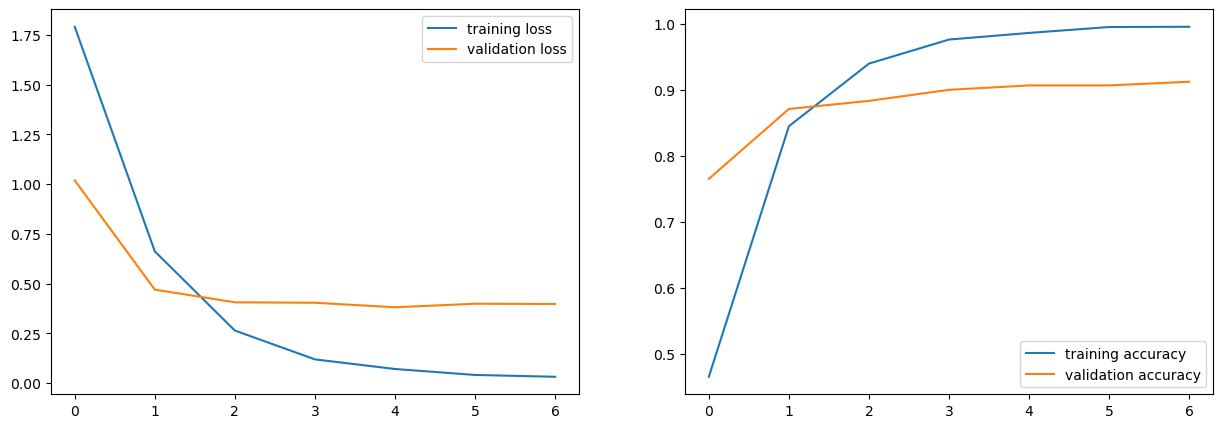

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(history['train_loss'])
plt.plot(history['val_loss'])
plt.legend(['training loss', 'validation loss'])
plt.subplot(122)
plt.plot(history['train_accuracy'])
plt.plot(history['val_accuracy'])
plt.legend(['training accuracy', 'validation accuracy'])

In [ ]:
eval(model, test_dataloader)

(0.48161853622144696, 0.8974358974358975)

In [ ]:
pred_logits = predict_batch(X_test, tokenizer)
pred_labels = np.argmax(pred_logits, axis=1)

In [ ]:
conf_matrix = confusion_matrix(y_test_int, pred_labels)
print(conf_matrix)

[[ 67   3   2   6   2   0   2   3   3   3]
 [  6  73   2   0   0   4   0   0   0   5]
 [  7   1  72   0   4   0   0   1   0   2]
 [  2   1   0  95   0   1   1   2   0   5]
 [  0   0   0   0  89   0   0   0   0   0]
 [  2   2   0   3   1  77   1   0   0   2]
 [  1   1   0   0   0   0  79   0   0   0]
 [  1   0   0   1   1   1   0 110   1   0]
 [  0   0   0   0   0   0   0   1  74   0]
 [  0   0   2   4   0   0   0   1   0  67]]


<AxesSubplot:>

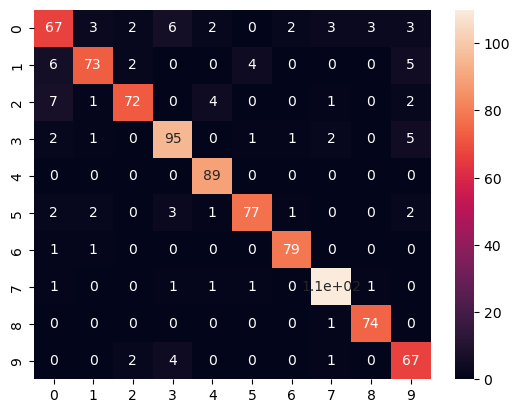

In [ ]:
sns.heatmap(conf_matrix, annot=True)

In [ ]:
print(classification_report(y_test_int, pred_labels))

              precision    recall  f1-score   support

           0       0.78      0.74      0.76        91
           1       0.90      0.81      0.85        90
           2       0.92      0.83      0.87        87
           3       0.87      0.89      0.88       107
           4       0.92      1.00      0.96        89
           5       0.93      0.88      0.90        88
           6       0.95      0.98      0.96        81
           7       0.93      0.96      0.94       115
           8       0.95      0.99      0.97        75
           9       0.80      0.91      0.85        74

    accuracy                           0.90       897
   macro avg       0.90      0.90      0.89       897
weighted avg       0.90      0.90      0.89       897



And now let's test it with some example questions:

In [ ]:
def classify(sentence, tokenizer):
    logits = predict(sentence, tokenizer)
    label_int = np.argmax(logits)
    return labels[label_int]

In [ ]:
print(classify('What is the application process?', tokenizer))
print(classify('What is the contact information?', tokenizer))
print(classify('how can i get to uni?', tokenizer))
print(classify('how many roads must a man walk past?', tokenizer))
print(classify('who is professor kasnesis?', tokenizer))
print(classify('who is professor xavier?', tokenizer))
print(classify('', tokenizer))


Applications
Contact
Contact
Irrelevant
Instructors
Irrelevant
Irrelevant


In [ ]:
model.save_pretrained('model')
tokenizer.save_pretrained('model')

('model/tokenizer_config.json',
 'model/special_tokens_map.json',
 'model/vocab.txt',
 'model/added_tokens.json',
 'model/tokenizer.json')